<a href="https://colab.research.google.com/github/chasubeen/ML_lab/blob/main/7_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Setup**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **parameter settings**

In [ ]:
## Hyperparameters

batch_size = 512
num_epochs = 200
latent_dim = 128 # 잠재 벡터의 크기(= 생성자의 입력과 동일)

# **1. Prepare data**

In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # 평균: 0.5, 표준편차: 0.5
])

In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True,
                               transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# **2. Modeling**

## **2-1. Generator(G)**

In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_dim):
    super(Generator, self).__init__()
    self.latent_dim = latent_dim
    self.model = nn.Sequential(
      nn.Linear(self.latent_dim, 256),
      nn.LeakyReLU(0.2),

      nn.Linear(256, 512),
      nn.LeakyReLU(0.2),

      nn.Linear(512, 1024),
      nn.LeakyReLU(0.2),

      nn.Linear(1024, 784),
      nn.Tanh()  # 출력 범위: [-1, 1]
    )

  def forward(self, x):
    return self.model(x)

## **2-2. Discriminator(D)**

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.n_input = 28*28
    self.model = nn.Sequential(
      nn.Linear(self.n_input, 1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),

      nn.Linear(1024, 512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),

      nn.Linear(512, 256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),

      nn.Linear(256, 1),
      nn.Sigmoid()  # 진짜 이미지와 가까울 확률을 반환
    )

  def forward(self, x):
    return self.model(x)

# **3. Training**

## **3-1. Model Initialization**

In [ ]:
generator = Generator(latent_dim).to(device) # 100, 256, 28*28
discriminator = Discriminator().to(device)

In [ ]:
print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [ ]:
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


## **3-2. Optimizer & loss function**

In [ ]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

## **3-3. Training functions**

In [ ]:
def train_discriminator(real_imgs, fake_imgs):
  optimizer_D.zero_grad()

  # Real images
  real_labels = torch.ones(real_imgs.size(0), 1).to(device)
  real_outputs = discriminator(real_imgs)
  d_loss_real = criterion(real_outputs, real_labels)
  d_loss_real.backward()

  # Fake images
  fake_labels = torch.zeros(fake_imgs.size(0), 1).to(device)
  fake_outputs = discriminator(fake_imgs)
  d_loss_fake = criterion(fake_outputs, fake_labels)
  d_loss_fake.backward()

  optimizer_D.step()

  return d_loss_real + d_loss_fake

In [ ]:
def train_generator(fake_imgs):
  optimizer_G.zero_grad()

  real_labels = torch.ones(fake_imgs.size(0), 1).to(device)  # 생성자는 가짜가 1임
  outputs = discriminator(fake_imgs)
  g_loss = criterion(outputs, real_labels) # discriminator를 얼마나 헷갈리게 하였는가
                                            # 실제와 얼마나 비슷한가
  g_loss.backward()

  optimizer_G.step()

  return g_loss

# **4. Run!!**

In [ ]:
def show_generated_imgs(epoch, generator, latent_dim, n_imgs=16):
  z = torch.randn(n_imgs, latent_dim).to(device)
  fake_imgs = generator(z).view(-1, 1, 28, 28).cpu().data
  grid_img = torchvision.utils.make_grid(fake_imgs, nrow=4, normalize=True)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.title(f'Epoch {epoch}')
  plt.show()

In [ ]:
g_losses = [] # 생성자 손실
d_losses = [] # 판별자 손실

Epoch 1/200: 100%|██████████| 118/118 [01:07<00:00,  1.74it/s]


Epoch [1/200], D Loss: 0.8515, G Loss: 1.3930


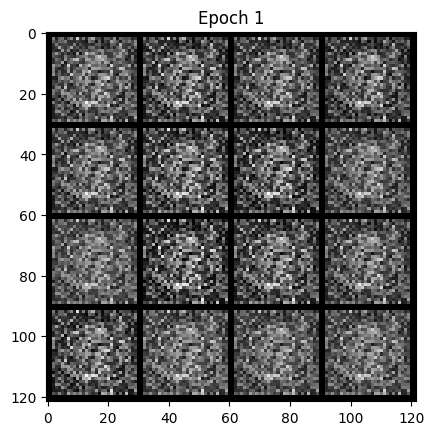

Epoch 2/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [2/200], D Loss: 1.5043, G Loss: 2.7871


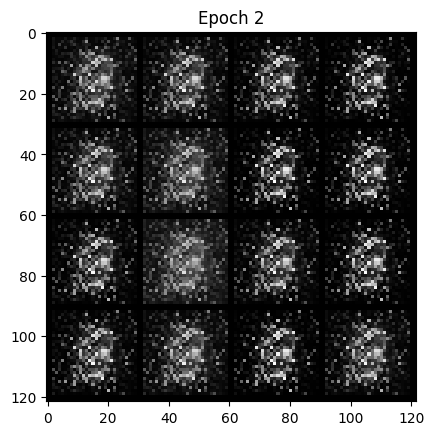

Epoch 3/200: 100%|██████████| 118/118 [01:04<00:00,  1.82it/s]


Epoch [3/200], D Loss: 0.5870, G Loss: 3.4807


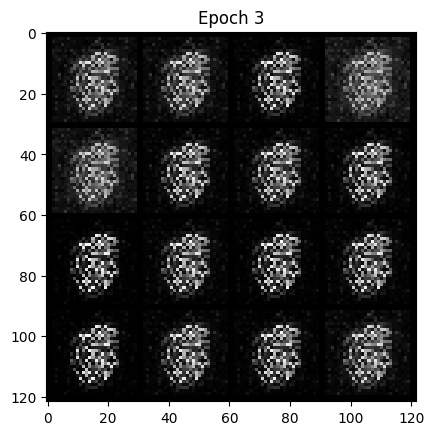

Epoch 4/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [4/200], D Loss: 0.9976, G Loss: 3.1978


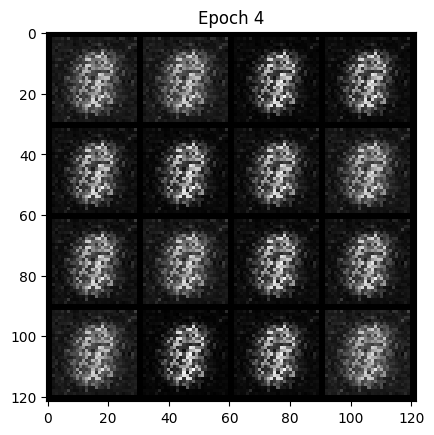

Epoch 5/200: 100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


Epoch [5/200], D Loss: 1.2417, G Loss: 2.3239


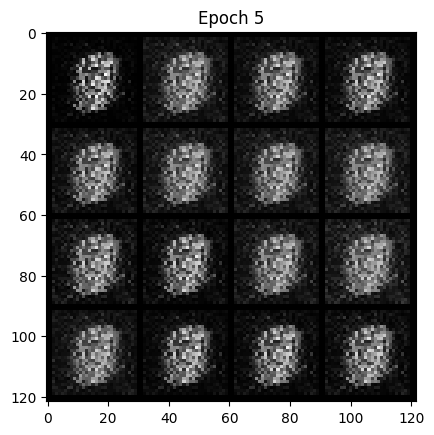

Epoch 6/200: 100%|██████████| 118/118 [01:01<00:00,  1.90it/s]


Epoch [6/200], D Loss: 1.1937, G Loss: 1.9655


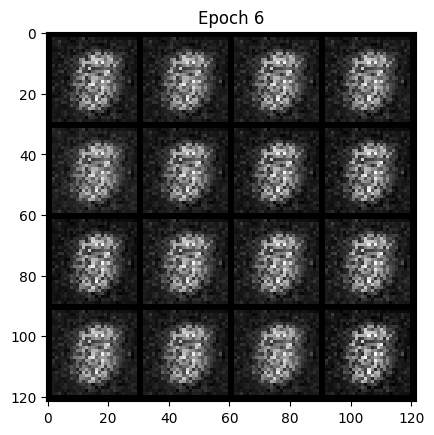

Epoch 7/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [7/200], D Loss: 0.9713, G Loss: 1.2469


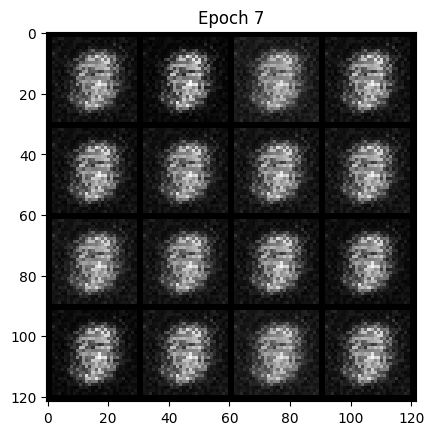

Epoch 8/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [8/200], D Loss: 1.1838, G Loss: 1.1022


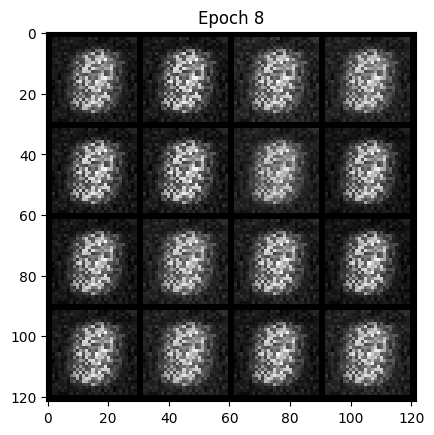

Epoch 9/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [9/200], D Loss: 0.9900, G Loss: 1.5579


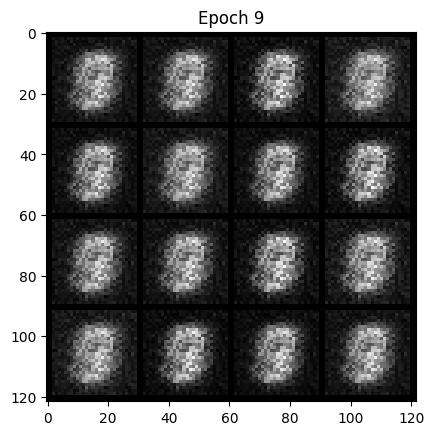

Epoch 10/200: 100%|██████████| 118/118 [01:00<00:00,  1.96it/s]


Epoch [10/200], D Loss: 1.2034, G Loss: 1.4664


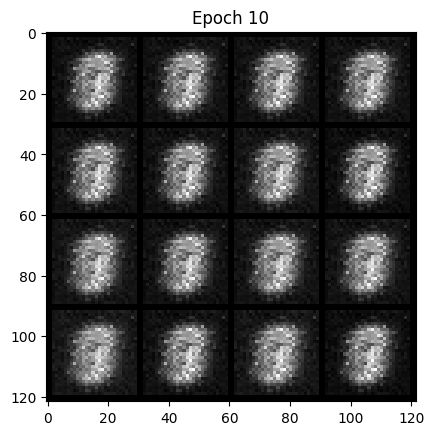

Epoch 11/200: 100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


Epoch [11/200], D Loss: 1.0063, G Loss: 1.2753


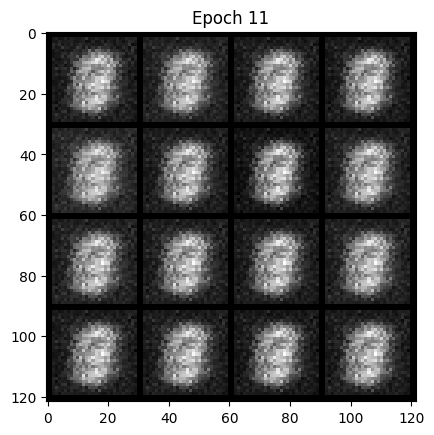

Epoch 12/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [12/200], D Loss: 0.7245, G Loss: 1.7822


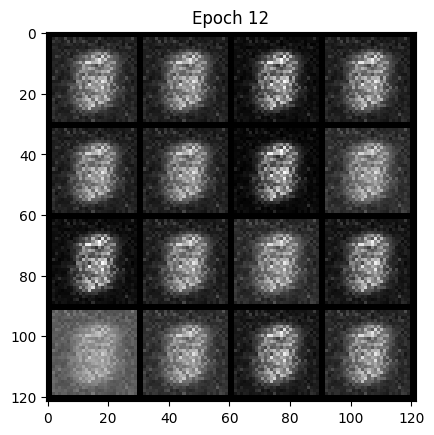

Epoch 13/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [13/200], D Loss: 0.4577, G Loss: 2.7146


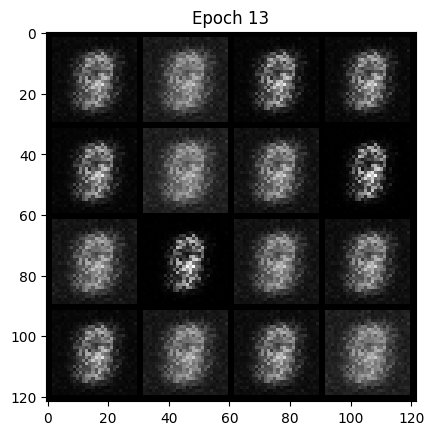

Epoch 14/200: 100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


Epoch [14/200], D Loss: 0.6085, G Loss: 3.5632


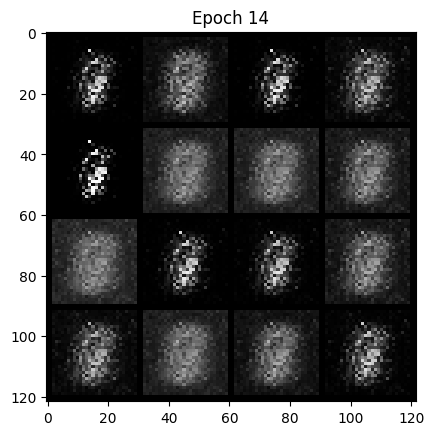

Epoch 15/200: 100%|██████████| 118/118 [01:00<00:00,  1.96it/s]


Epoch [15/200], D Loss: 0.4717, G Loss: 2.9694


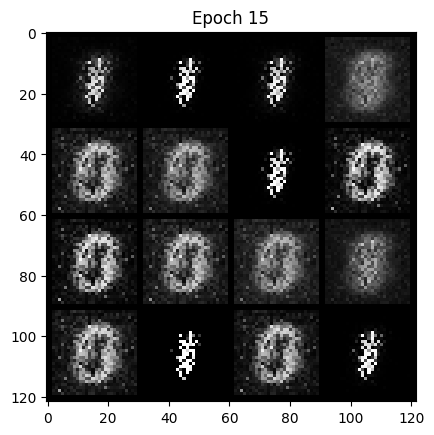

Epoch 16/200: 100%|██████████| 118/118 [01:00<00:00,  1.97it/s]


Epoch [16/200], D Loss: 0.3205, G Loss: 3.3259


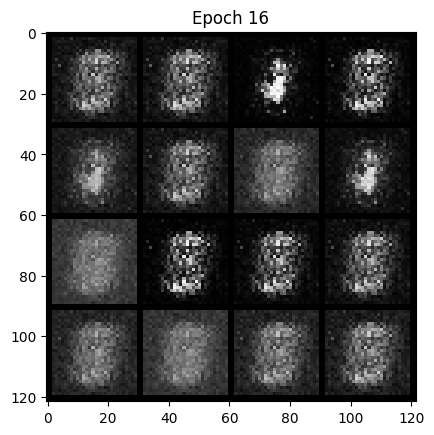

Epoch 17/200: 100%|██████████| 118/118 [01:00<00:00,  1.95it/s]


Epoch [17/200], D Loss: 0.3948, G Loss: 3.7522


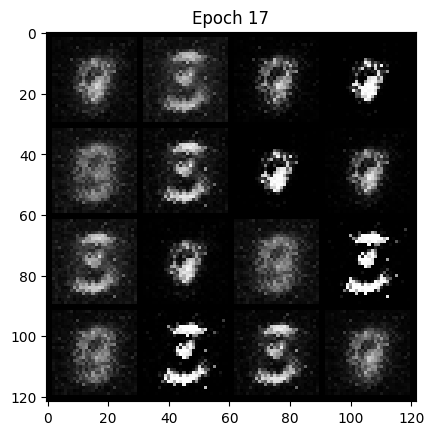

Epoch 18/200: 100%|██████████| 118/118 [01:00<00:00,  1.96it/s]


Epoch [18/200], D Loss: 0.4878, G Loss: 3.2113


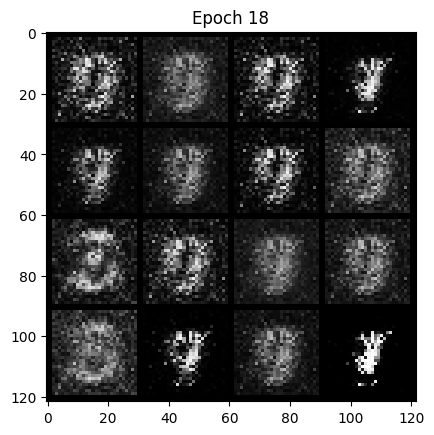

Epoch 19/200: 100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


Epoch [19/200], D Loss: 0.4555, G Loss: 3.5671


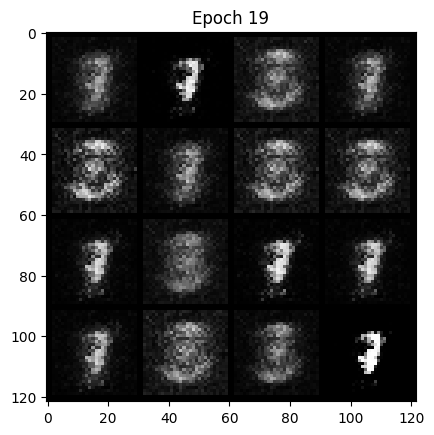

Epoch 20/200: 100%|██████████| 118/118 [01:00<00:00,  1.96it/s]


Epoch [20/200], D Loss: 0.5329, G Loss: 3.2808


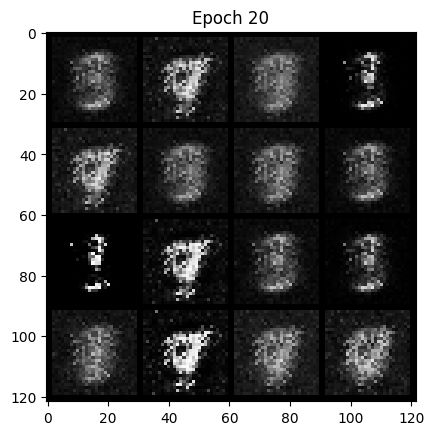

Epoch 21/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [21/200], D Loss: 0.5435, G Loss: 2.9670


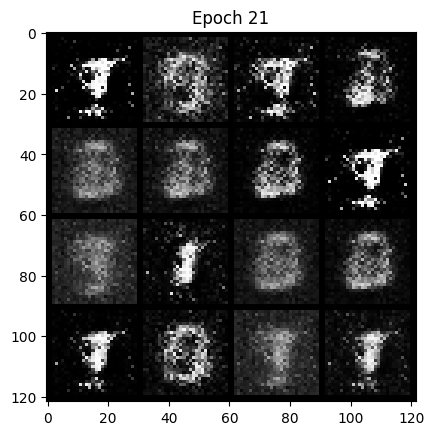

Epoch 22/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [22/200], D Loss: 0.4994, G Loss: 3.3581


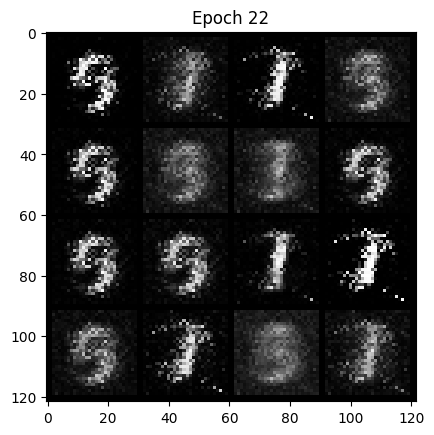

Epoch 23/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [23/200], D Loss: 0.4786, G Loss: 3.5786


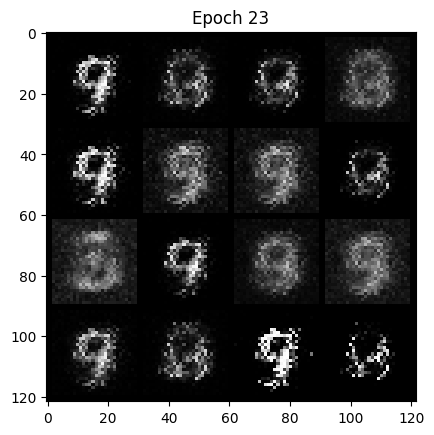

Epoch 24/200: 100%|██████████| 118/118 [01:03<00:00,  1.85it/s]


Epoch [24/200], D Loss: 0.4907, G Loss: 3.2336


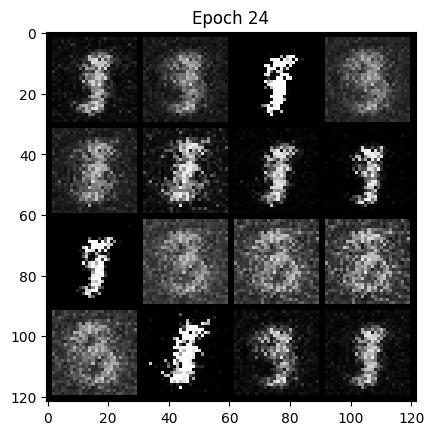

Epoch 25/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [25/200], D Loss: 0.5431, G Loss: 3.2807


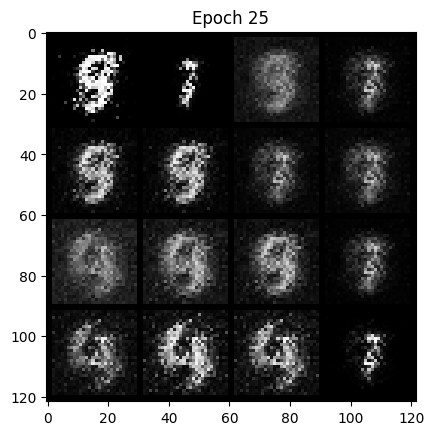

Epoch 26/200: 100%|██████████| 118/118 [01:01<00:00,  1.90it/s]


Epoch [26/200], D Loss: 0.3762, G Loss: 3.5919


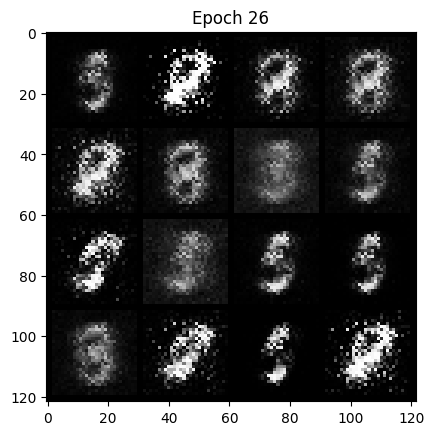

Epoch 27/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [27/200], D Loss: 0.5249, G Loss: 3.1223


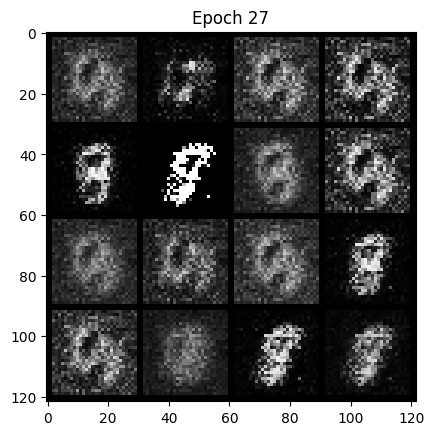

Epoch 28/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [28/200], D Loss: 0.3638, G Loss: 3.8178


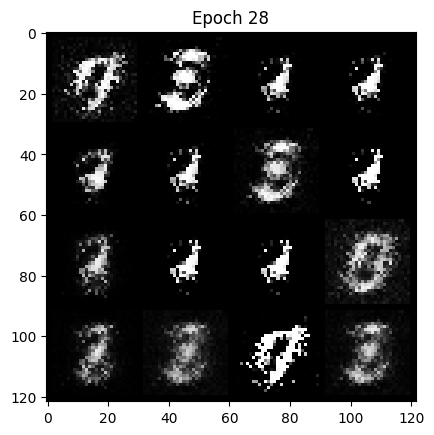

Epoch 29/200: 100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


Epoch [29/200], D Loss: 0.4311, G Loss: 3.4721


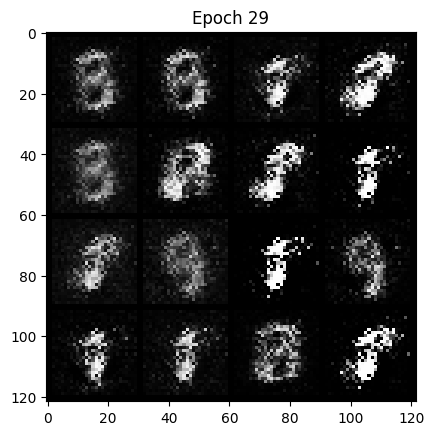

Epoch 30/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [30/200], D Loss: 0.4841, G Loss: 3.5469


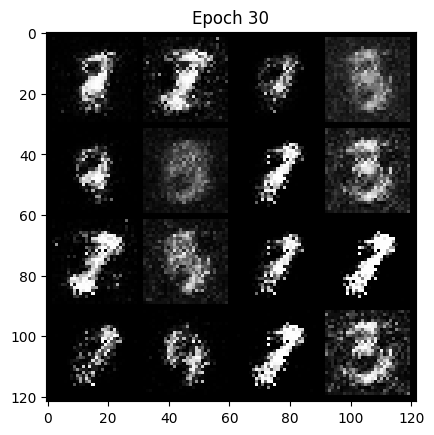

Epoch 31/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [31/200], D Loss: 0.4005, G Loss: 3.3630


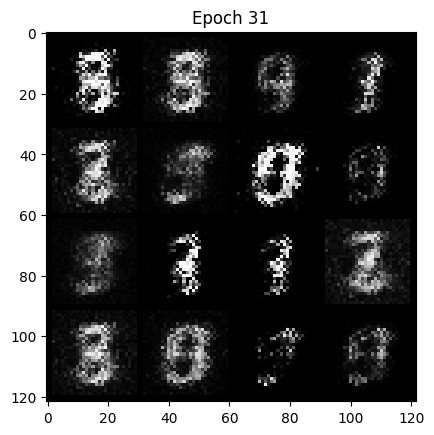

Epoch 32/200: 100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


Epoch [32/200], D Loss: 0.3889, G Loss: 3.6015


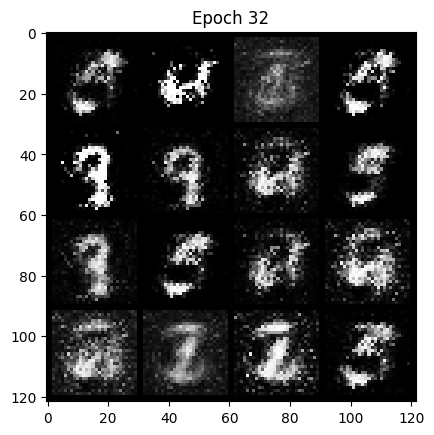

Epoch 33/200: 100%|██████████| 118/118 [01:02<00:00,  1.87it/s]


Epoch [33/200], D Loss: 0.4793, G Loss: 3.1532


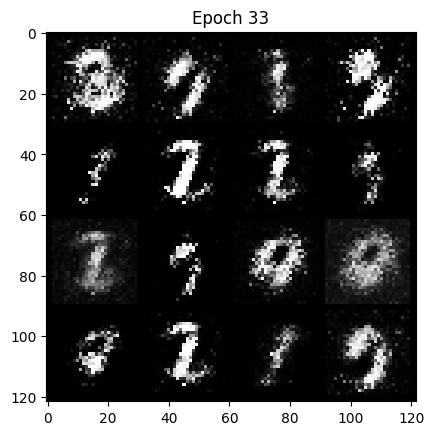

Epoch 34/200: 100%|██████████| 118/118 [01:04<00:00,  1.84it/s]


Epoch [34/200], D Loss: 0.4026, G Loss: 3.3895


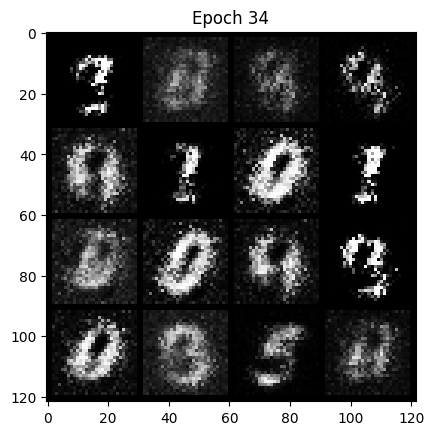

Epoch 35/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [35/200], D Loss: 0.3607, G Loss: 3.4944


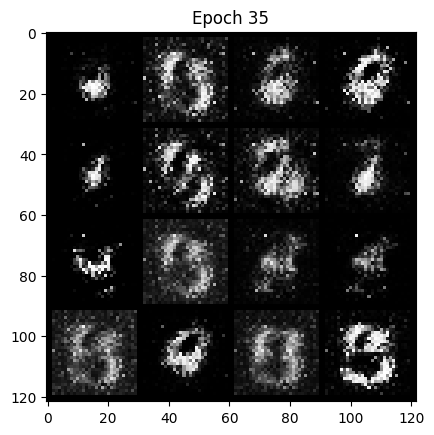

Epoch 36/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [36/200], D Loss: 0.3599, G Loss: 3.8241


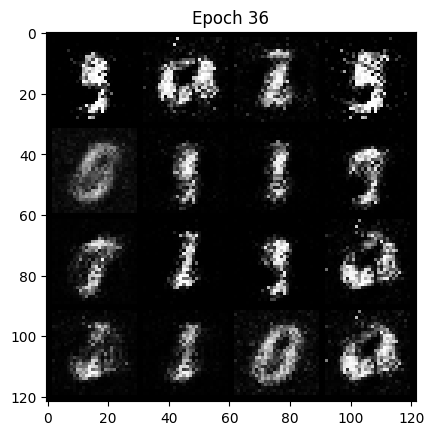

Epoch 37/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [37/200], D Loss: 0.4028, G Loss: 3.3613


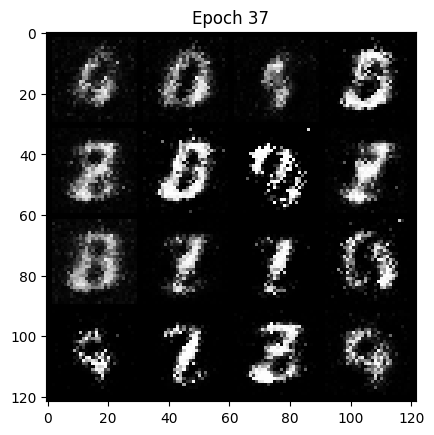

Epoch 38/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [38/200], D Loss: 0.3802, G Loss: 3.4858


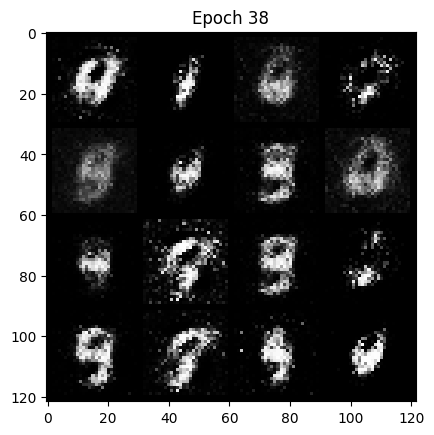

Epoch 39/200: 100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


Epoch [39/200], D Loss: 0.3792, G Loss: 3.3480


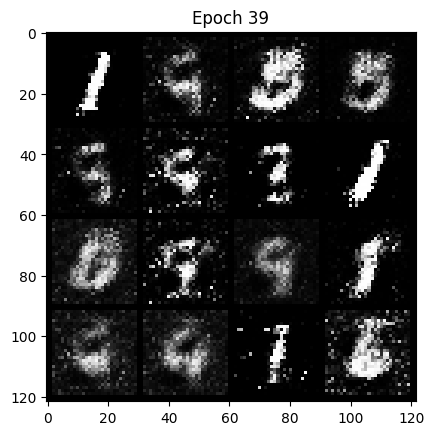

Epoch 40/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [40/200], D Loss: 0.3602, G Loss: 3.4453


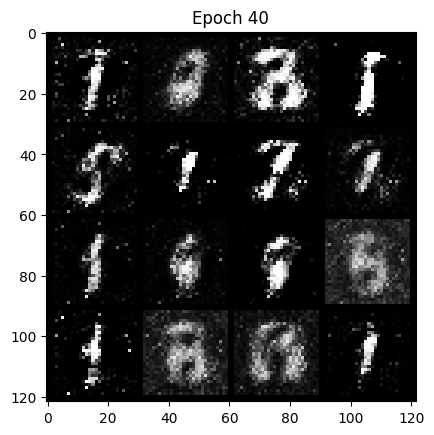

Epoch 41/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [41/200], D Loss: 0.4115, G Loss: 3.3494


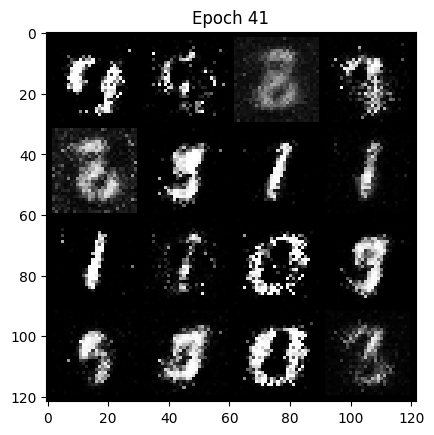

Epoch 42/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [42/200], D Loss: 0.4159, G Loss: 3.4665


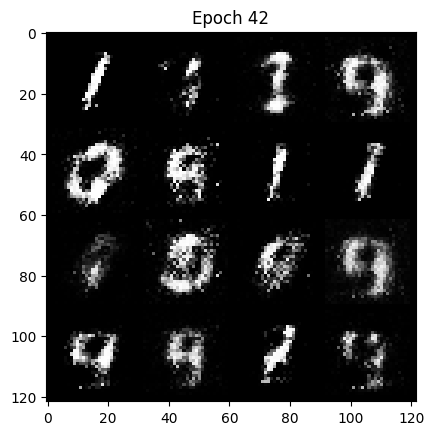

Epoch 43/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [43/200], D Loss: 0.4602, G Loss: 3.0459


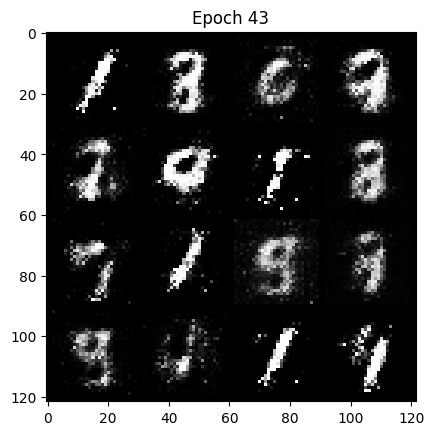

Epoch 44/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [44/200], D Loss: 0.4586, G Loss: 3.2372


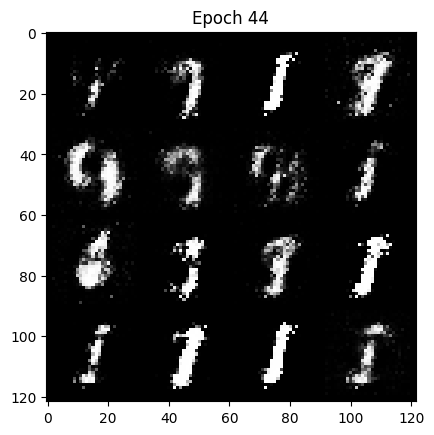

Epoch 45/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [45/200], D Loss: 0.4512, G Loss: 2.9784


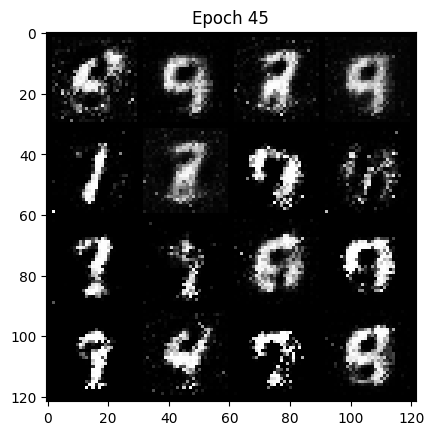

Epoch 46/200: 100%|██████████| 118/118 [01:02<00:00,  1.87it/s]


Epoch [46/200], D Loss: 0.4770, G Loss: 2.9146


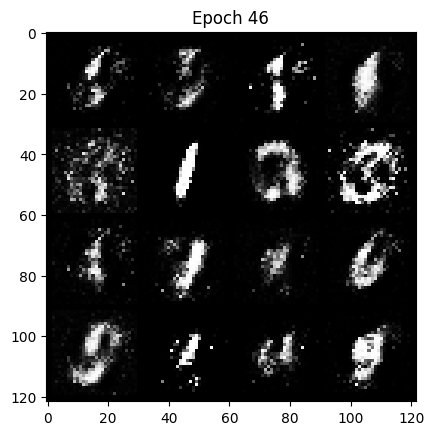

Epoch 47/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [47/200], D Loss: 0.4680, G Loss: 3.0483


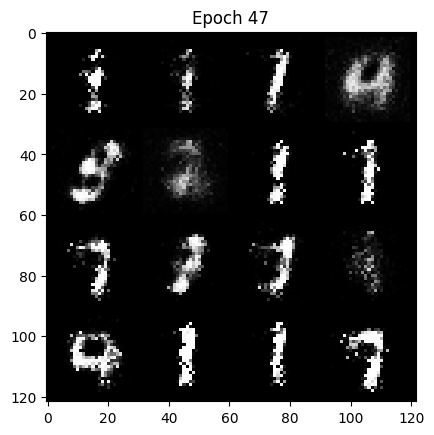

Epoch 48/200: 100%|██████████| 118/118 [01:00<00:00,  1.95it/s]


Epoch [48/200], D Loss: 0.4562, G Loss: 3.0838


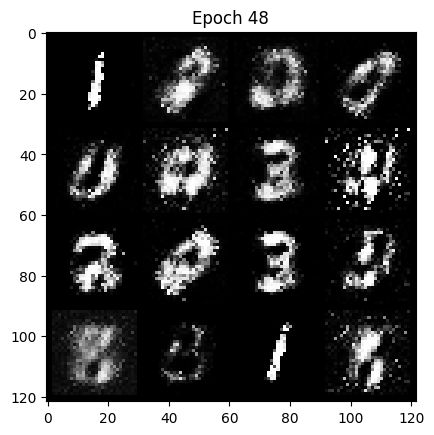

Epoch 49/200: 100%|██████████| 118/118 [01:01<00:00,  1.90it/s]


Epoch [49/200], D Loss: 0.4942, G Loss: 2.9470


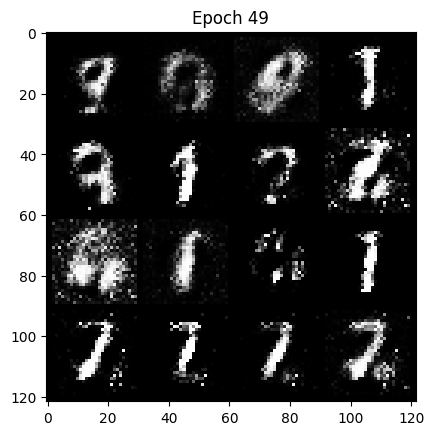

Epoch 50/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [50/200], D Loss: 0.5120, G Loss: 2.7583


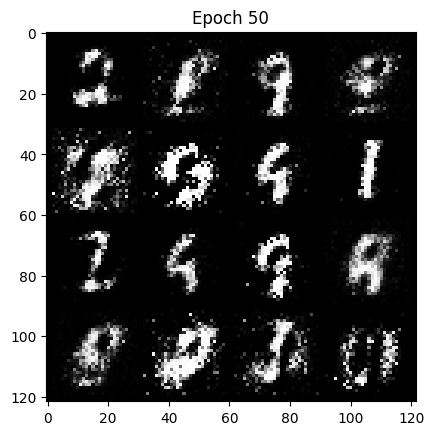

Epoch 51/200: 100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


Epoch [51/200], D Loss: 0.4899, G Loss: 2.9908


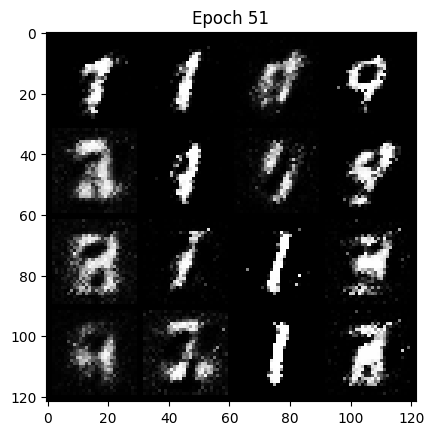

Epoch 52/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [52/200], D Loss: 0.4900, G Loss: 2.7575


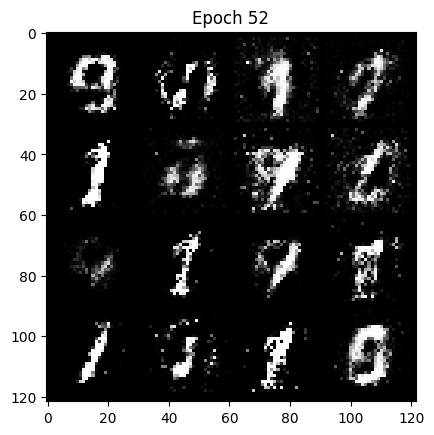

Epoch 53/200: 100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


Epoch [53/200], D Loss: 0.5728, G Loss: 2.6444


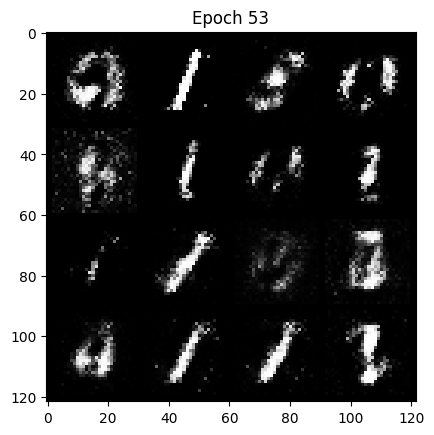

Epoch 54/200: 100%|██████████| 118/118 [01:00<00:00,  1.95it/s]


Epoch [54/200], D Loss: 0.5206, G Loss: 2.6958


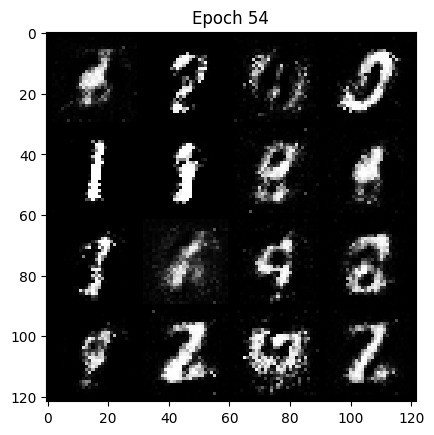

Epoch 55/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [55/200], D Loss: 0.4970, G Loss: 2.8548


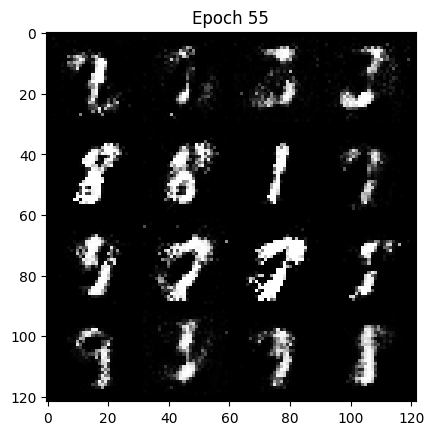

Epoch 56/200: 100%|██████████| 118/118 [01:06<00:00,  1.78it/s]


Epoch [56/200], D Loss: 0.5430, G Loss: 2.7510


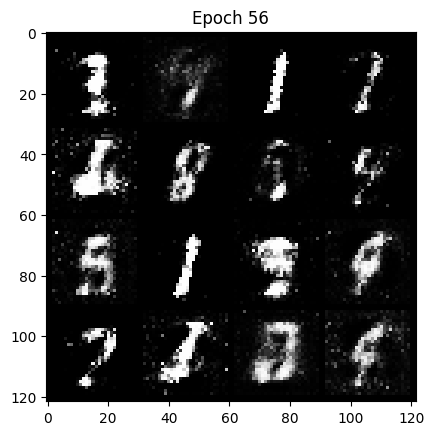

Epoch 57/200: 100%|██████████| 118/118 [01:18<00:00,  1.50it/s]


Epoch [57/200], D Loss: 0.5151, G Loss: 2.7988


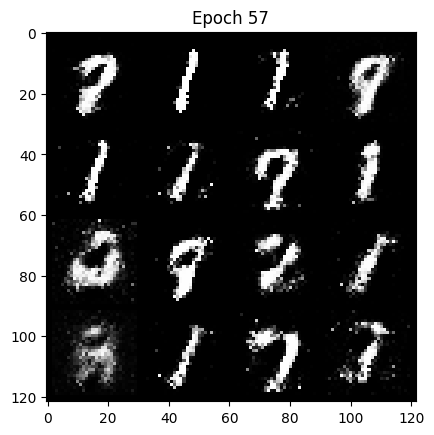

Epoch 58/200: 100%|██████████| 118/118 [01:07<00:00,  1.76it/s]


Epoch [58/200], D Loss: 0.5177, G Loss: 2.8255


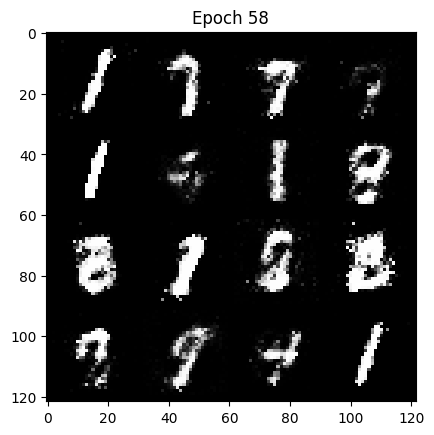

Epoch 59/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [59/200], D Loss: 0.5336, G Loss: 2.6851


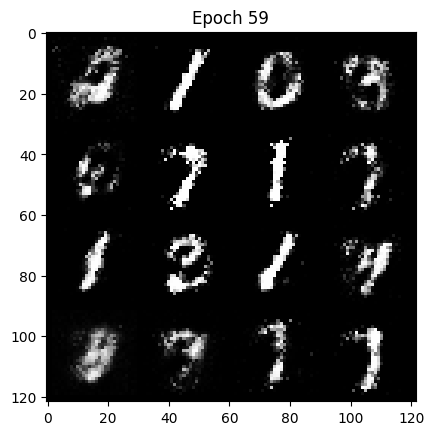

Epoch 60/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [60/200], D Loss: 0.5429, G Loss: 2.7702


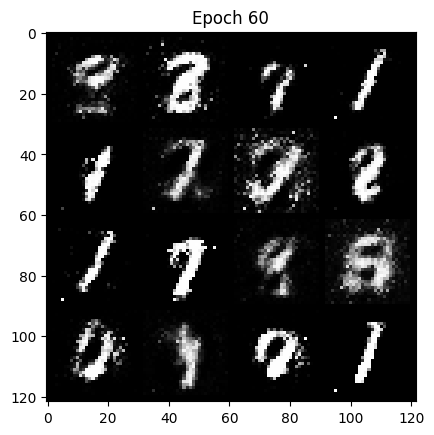

Epoch 61/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [61/200], D Loss: 0.5565, G Loss: 2.7450


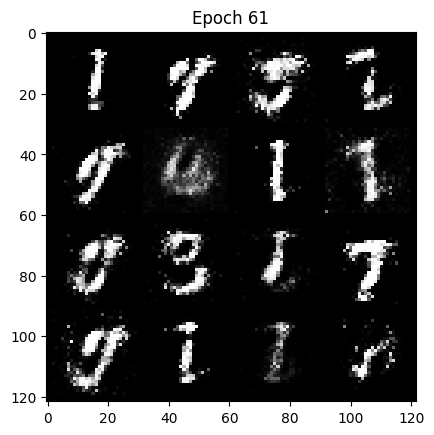

Epoch 62/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [62/200], D Loss: 0.5818, G Loss: 2.6794


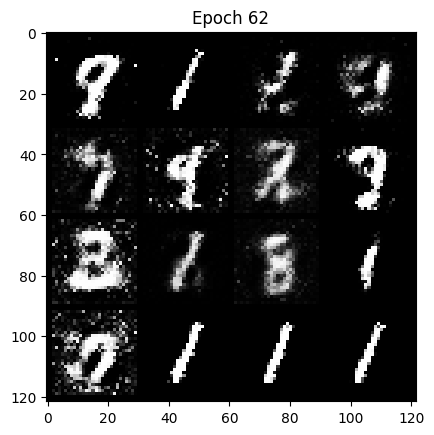

Epoch 63/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [63/200], D Loss: 0.5830, G Loss: 2.5193


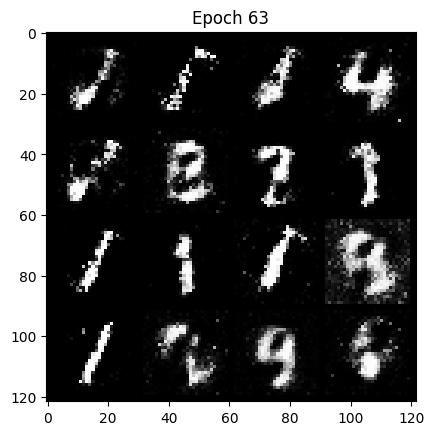

Epoch 64/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [64/200], D Loss: 0.5963, G Loss: 2.4999


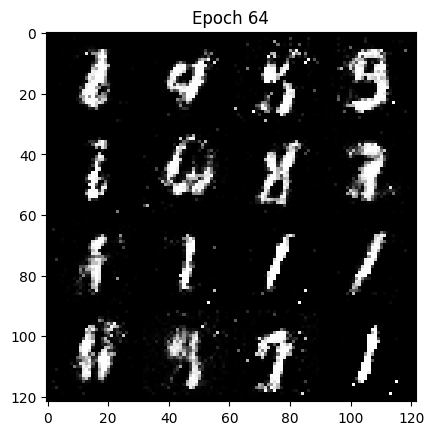

Epoch 65/200: 100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


Epoch [65/200], D Loss: 0.5741, G Loss: 2.6004


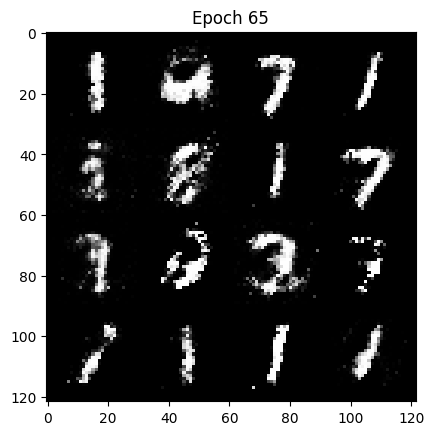

Epoch 66/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [66/200], D Loss: 0.5399, G Loss: 2.7123


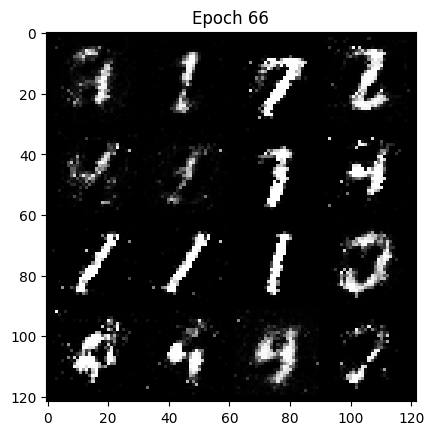

Epoch 67/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [67/200], D Loss: 0.5783, G Loss: 2.7171


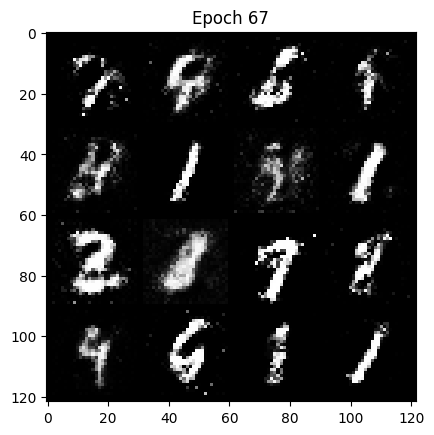

Epoch 68/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [68/200], D Loss: 0.5811, G Loss: 2.6527


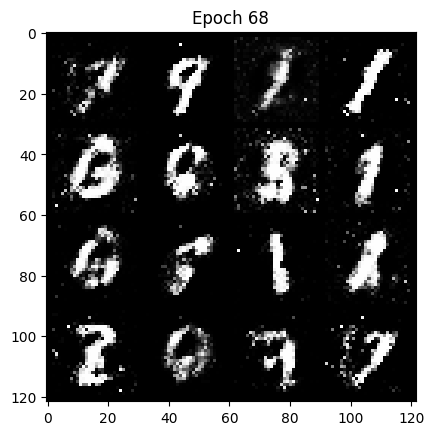

Epoch 69/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [69/200], D Loss: 0.5706, G Loss: 2.6136


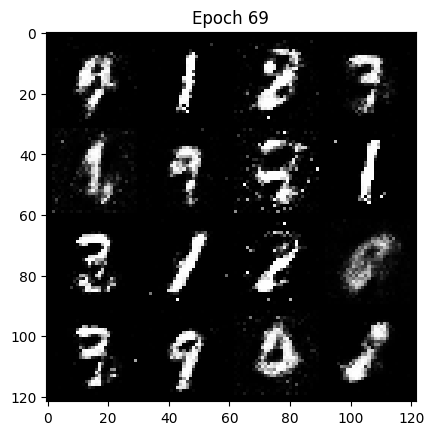

Epoch 70/200: 100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


Epoch [70/200], D Loss: 0.6139, G Loss: 2.4387


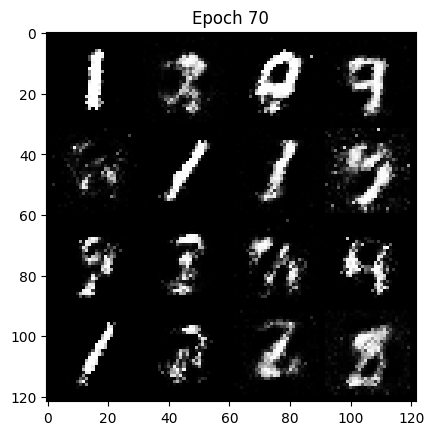

Epoch 71/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [71/200], D Loss: 0.5825, G Loss: 2.5047


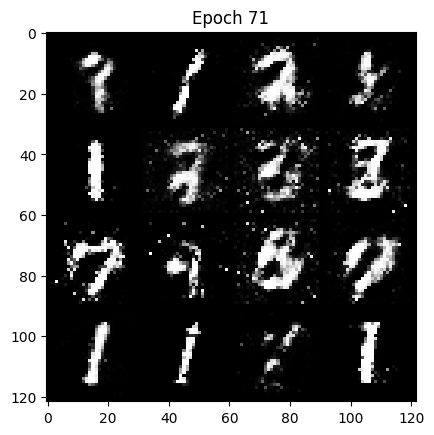

Epoch 72/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [72/200], D Loss: 0.5659, G Loss: 2.5997


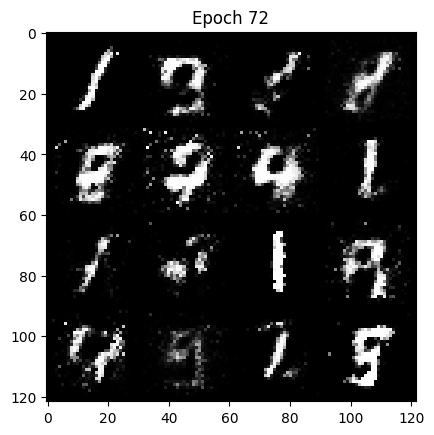

Epoch 73/200: 100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


Epoch [73/200], D Loss: 0.5574, G Loss: 2.5675


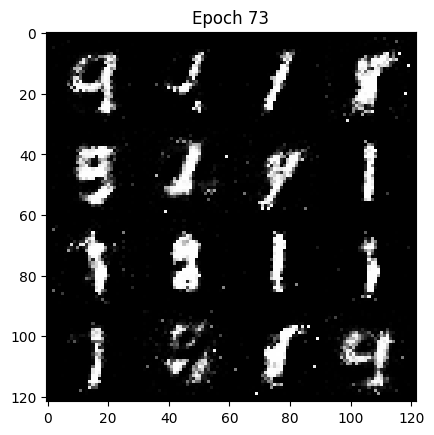

Epoch 74/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [74/200], D Loss: 0.5848, G Loss: 2.5602


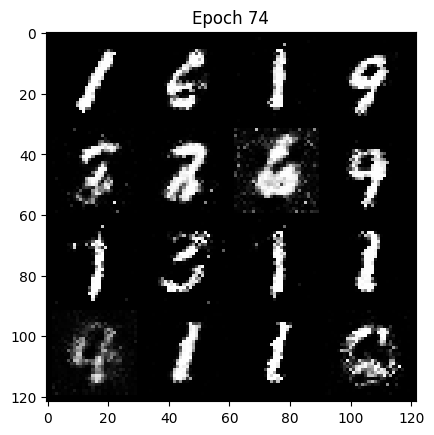

Epoch 75/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [75/200], D Loss: 0.6558, G Loss: 2.3761


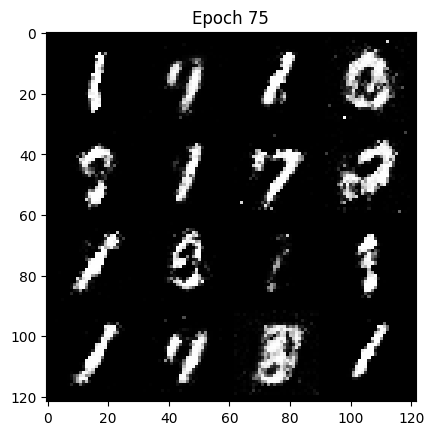

Epoch 76/200: 100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


Epoch [76/200], D Loss: 0.6520, G Loss: 2.2656


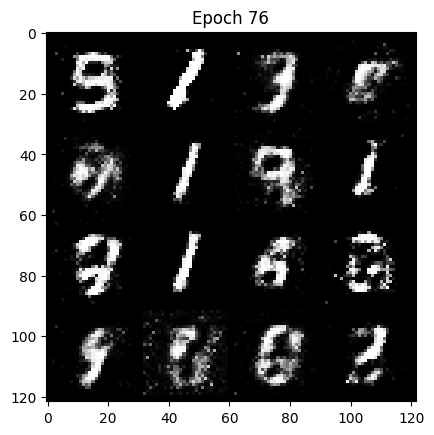

Epoch 77/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [77/200], D Loss: 0.6584, G Loss: 2.3137


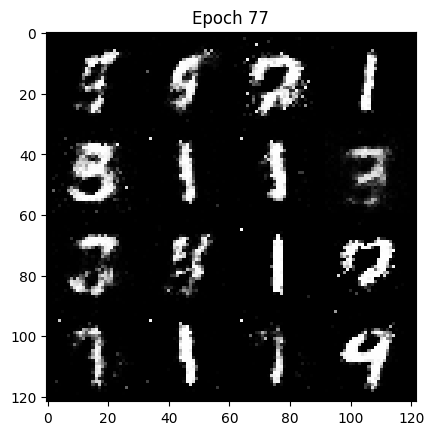

Epoch 78/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [78/200], D Loss: 0.6646, G Loss: 2.3231


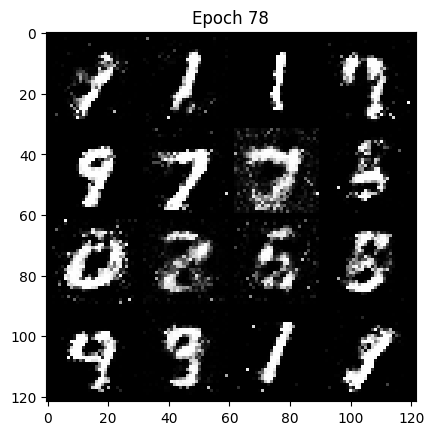

Epoch 79/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [79/200], D Loss: 0.7001, G Loss: 2.2266


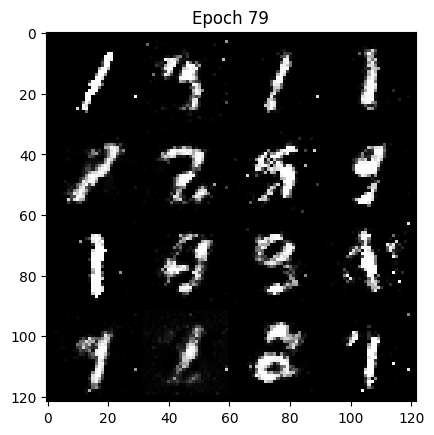

Epoch 80/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [80/200], D Loss: 0.6903, G Loss: 2.1576


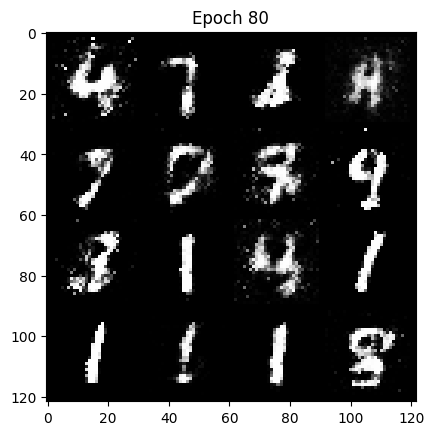

Epoch 81/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [81/200], D Loss: 0.6830, G Loss: 2.1857


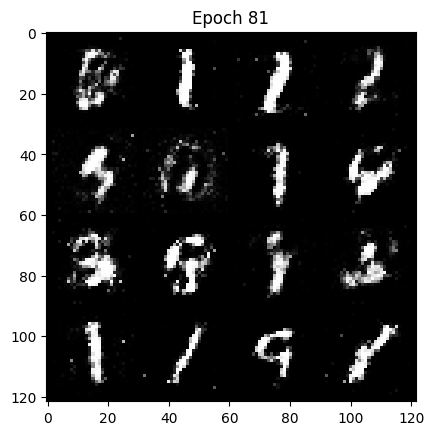

Epoch 82/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [82/200], D Loss: 0.7264, G Loss: 2.1578


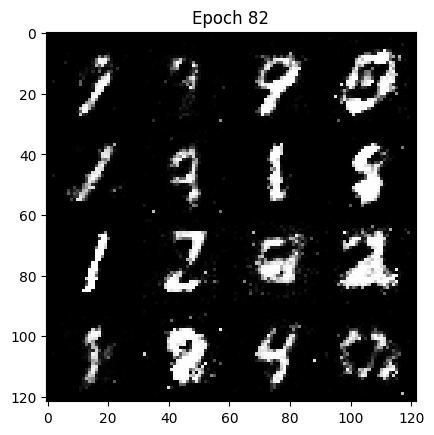

Epoch 83/200: 100%|██████████| 118/118 [01:04<00:00,  1.82it/s]


Epoch [83/200], D Loss: 0.6720, G Loss: 2.1940


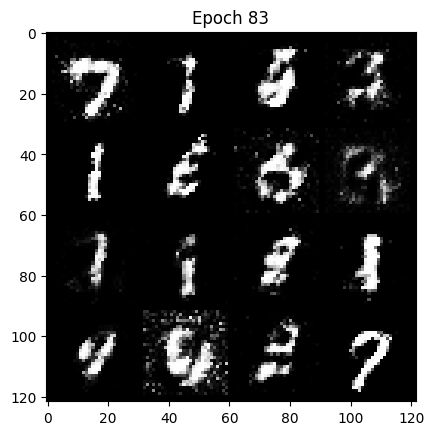

Epoch 84/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [84/200], D Loss: 0.7374, G Loss: 2.0398


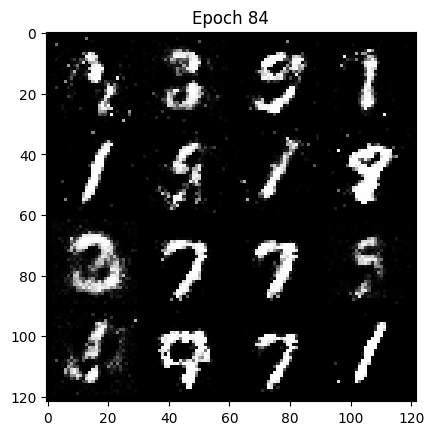

Epoch 85/200: 100%|██████████| 118/118 [01:02<00:00,  1.87it/s]


Epoch [85/200], D Loss: 0.7617, G Loss: 1.9783


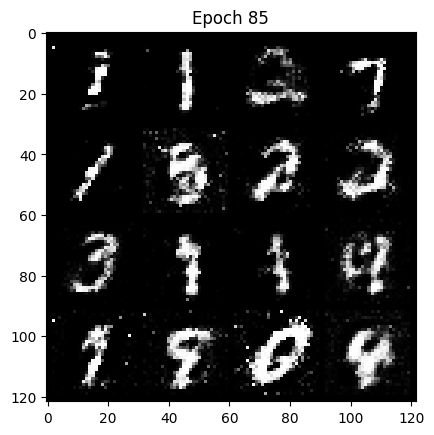

Epoch 86/200: 100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


Epoch [86/200], D Loss: 0.7125, G Loss: 2.1034


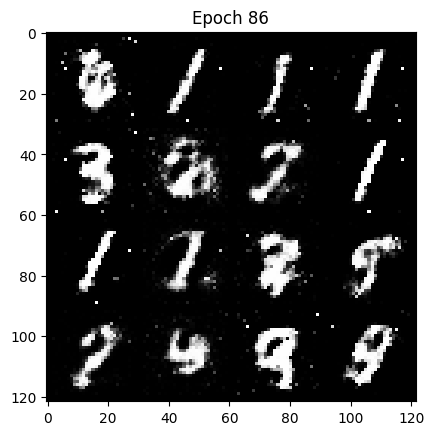

Epoch 87/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [87/200], D Loss: 0.7234, G Loss: 2.1028


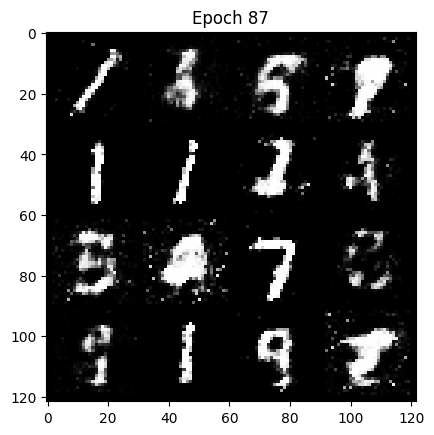

Epoch 88/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [88/200], D Loss: 0.7527, G Loss: 2.0312


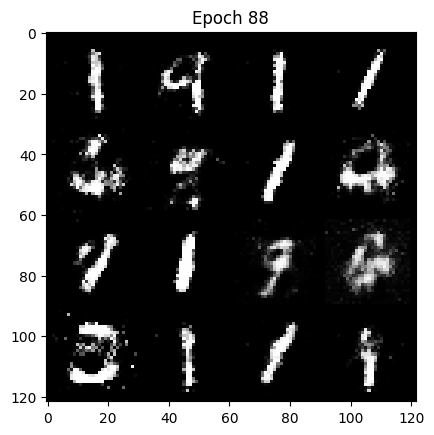

Epoch 89/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [89/200], D Loss: 0.7899, G Loss: 1.9350


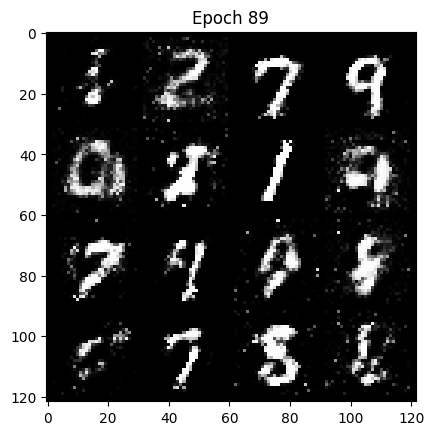

Epoch 90/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [90/200], D Loss: 0.7913, G Loss: 1.9889


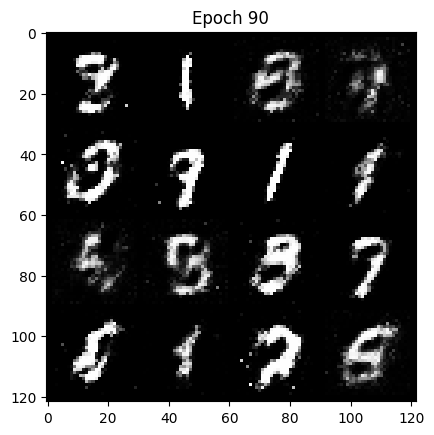

Epoch 91/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [91/200], D Loss: 0.7131, G Loss: 2.1275


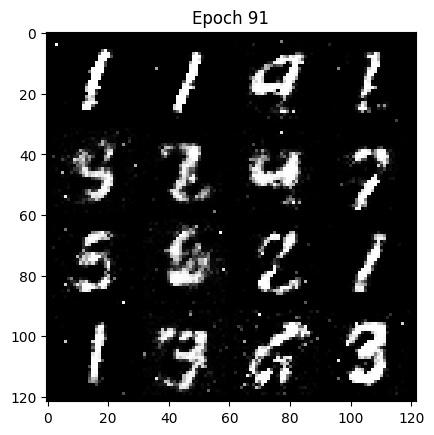

Epoch 92/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [92/200], D Loss: 0.7749, G Loss: 1.9996


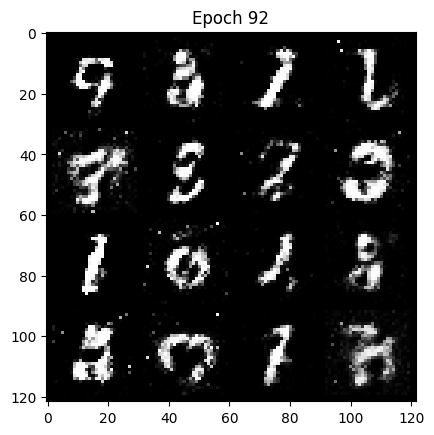

Epoch 93/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [93/200], D Loss: 0.7767, G Loss: 1.9742


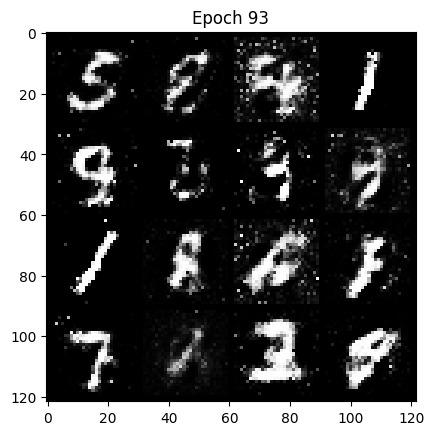

Epoch 94/200: 100%|██████████| 118/118 [01:00<00:00,  1.94it/s]


Epoch [94/200], D Loss: 0.7691, G Loss: 1.9619


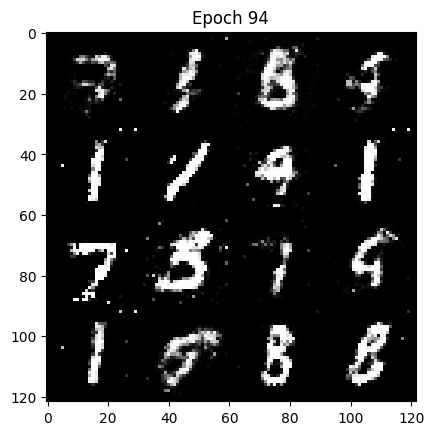

Epoch 95/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [95/200], D Loss: 0.7759, G Loss: 1.9659


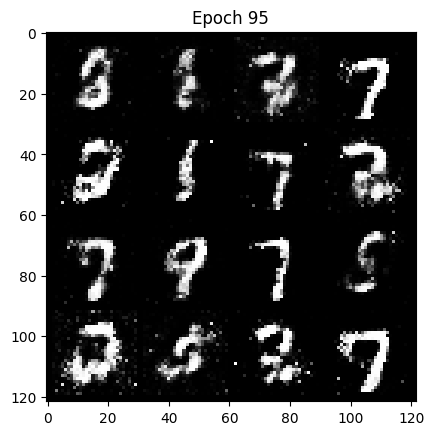

Epoch 96/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [96/200], D Loss: 0.7993, G Loss: 1.9684


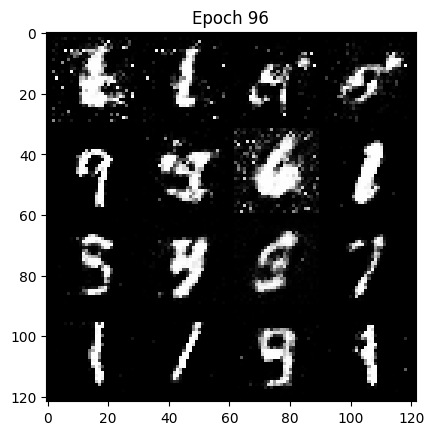

Epoch 97/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [97/200], D Loss: 0.8230, G Loss: 1.8701


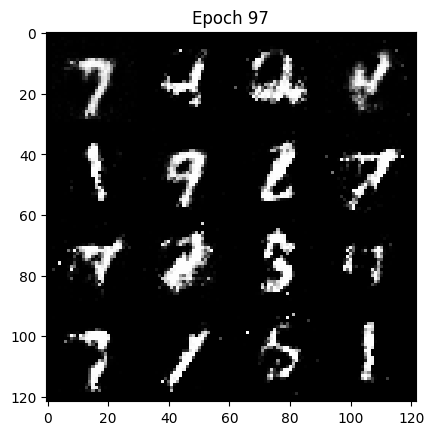

Epoch 98/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [98/200], D Loss: 0.7755, G Loss: 1.9243


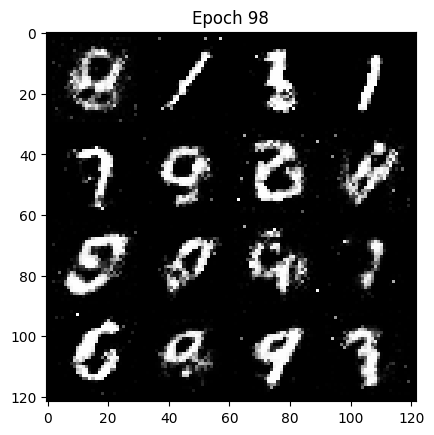

Epoch 99/200: 100%|██████████| 118/118 [01:02<00:00,  1.87it/s]


Epoch [99/200], D Loss: 0.7826, G Loss: 2.0362


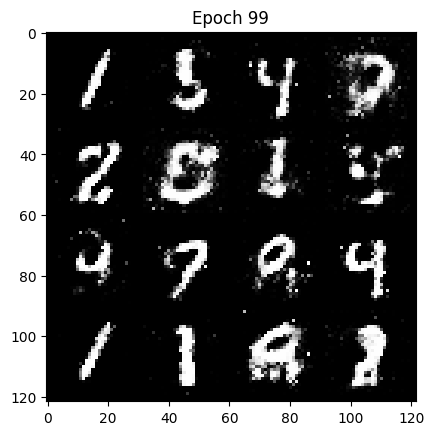

Epoch 100/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [100/200], D Loss: 0.7823, G Loss: 1.9692


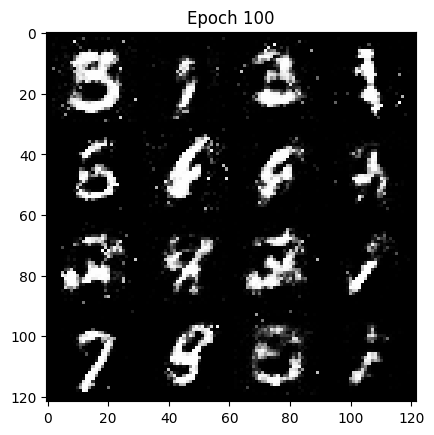

Epoch 101/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [101/200], D Loss: 0.8147, G Loss: 1.8725


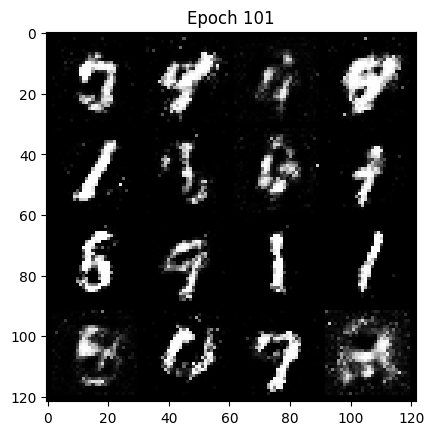

Epoch 102/200: 100%|██████████| 118/118 [01:03<00:00,  1.84it/s]


Epoch [102/200], D Loss: 0.8233, G Loss: 1.8758


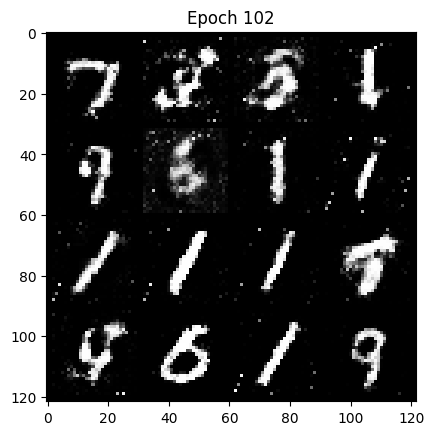

Epoch 103/200: 100%|██████████| 118/118 [01:02<00:00,  1.87it/s]


Epoch [103/200], D Loss: 0.8547, G Loss: 1.7828


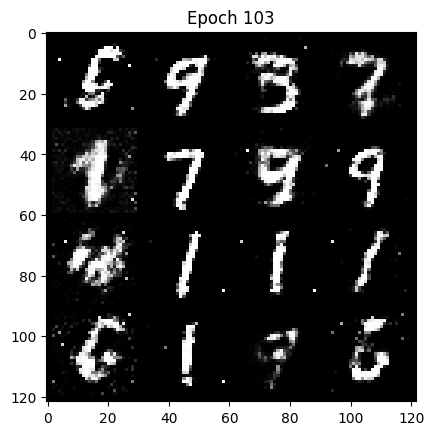

Epoch 104/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [104/200], D Loss: 0.8577, G Loss: 1.7802


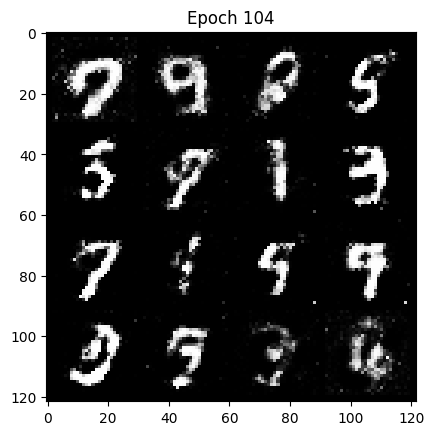

Epoch 105/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [105/200], D Loss: 0.8219, G Loss: 1.7911


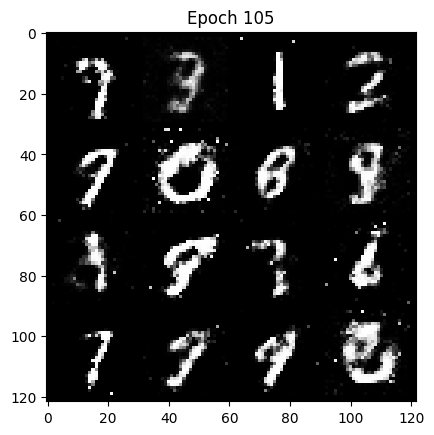

Epoch 106/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [106/200], D Loss: 0.8234, G Loss: 1.8108


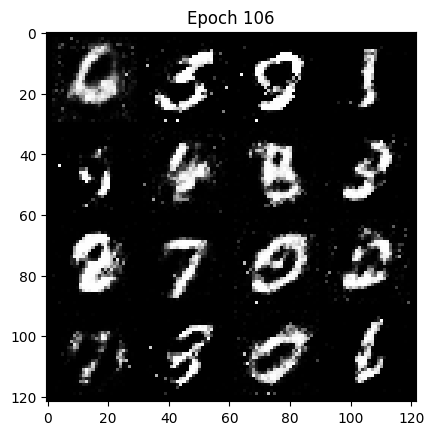

Epoch 107/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [107/200], D Loss: 0.8130, G Loss: 1.8024


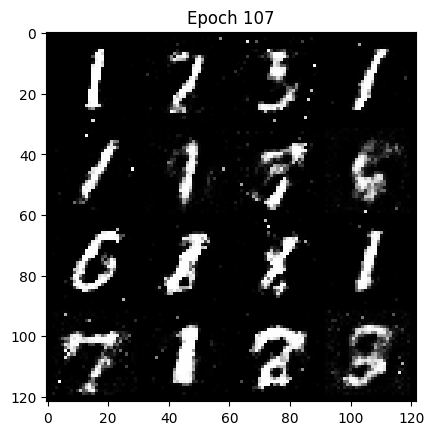

Epoch 108/200: 100%|██████████| 118/118 [01:04<00:00,  1.84it/s]


Epoch [108/200], D Loss: 0.8331, G Loss: 1.8110


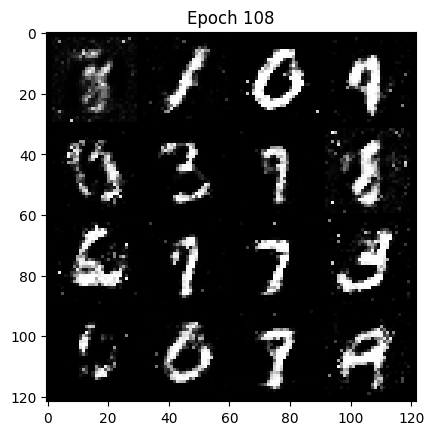

Epoch 109/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [109/200], D Loss: 0.8568, G Loss: 1.8275


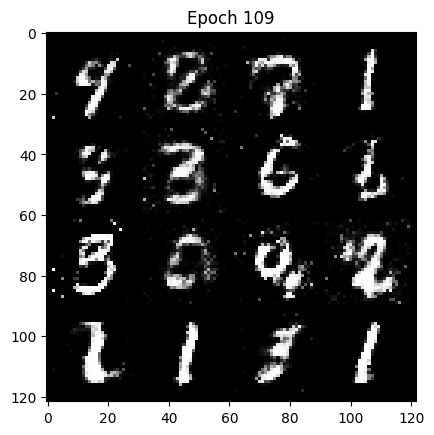

Epoch 110/200: 100%|██████████| 118/118 [01:05<00:00,  1.80it/s]


Epoch [110/200], D Loss: 0.8205, G Loss: 1.8609


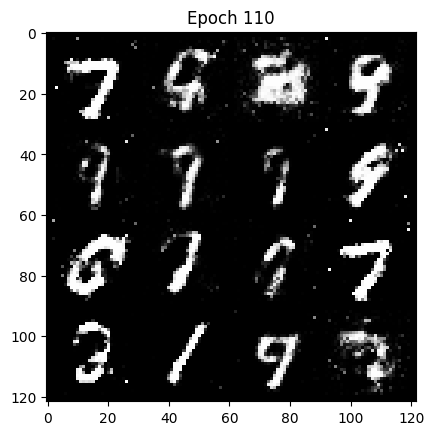

Epoch 111/200: 100%|██████████| 118/118 [01:15<00:00,  1.57it/s]


Epoch [111/200], D Loss: 0.8578, G Loss: 1.7455


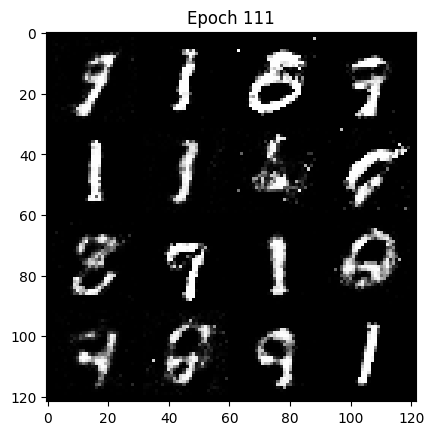

Epoch 112/200: 100%|██████████| 118/118 [01:05<00:00,  1.80it/s]


Epoch [112/200], D Loss: 0.8441, G Loss: 1.7528


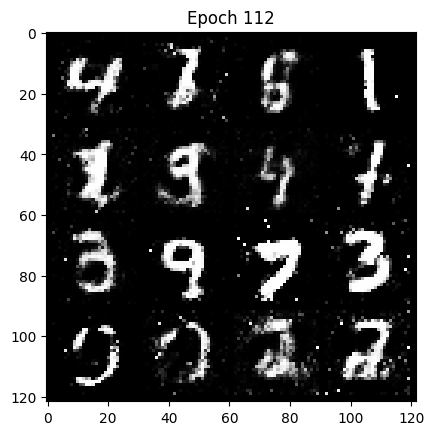

Epoch 113/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [113/200], D Loss: 0.8955, G Loss: 1.7268


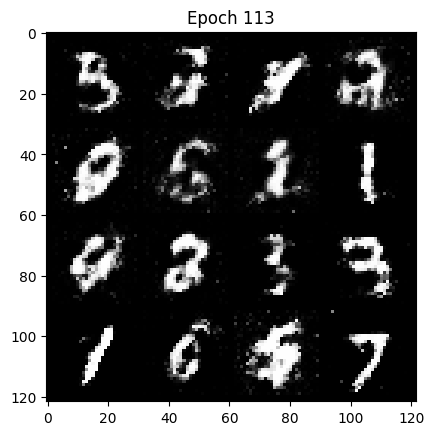

Epoch 114/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [114/200], D Loss: 0.8966, G Loss: 1.6045


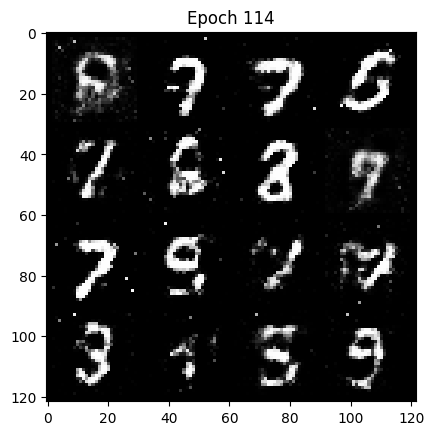

Epoch 115/200: 100%|██████████| 118/118 [01:02<00:00,  1.87it/s]


Epoch [115/200], D Loss: 0.8699, G Loss: 1.6888


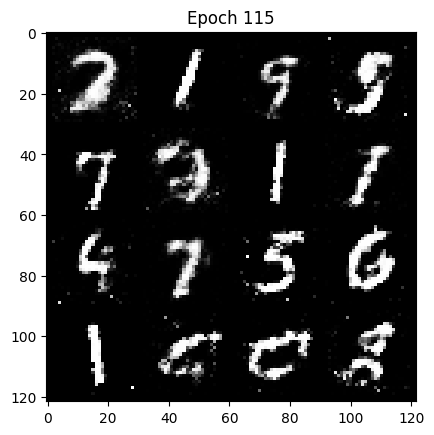

Epoch 116/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [116/200], D Loss: 0.8739, G Loss: 1.6993


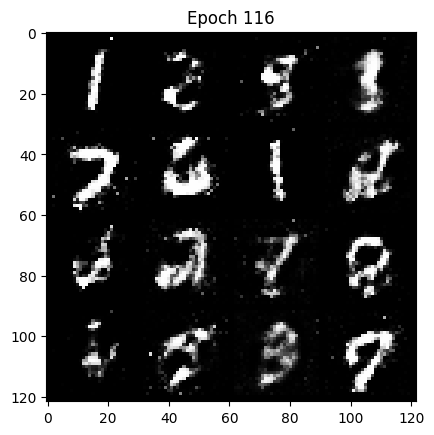

Epoch 117/200: 100%|██████████| 118/118 [01:04<00:00,  1.84it/s]


Epoch [117/200], D Loss: 0.8938, G Loss: 1.6534


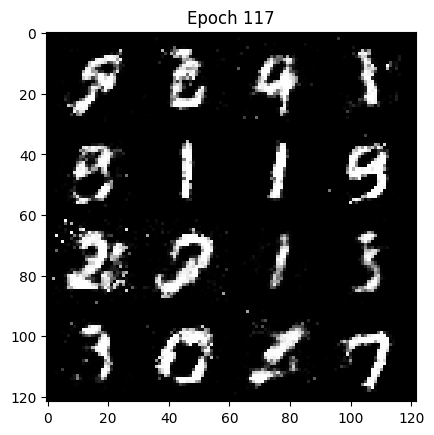

Epoch 118/200: 100%|██████████| 118/118 [01:12<00:00,  1.62it/s]


Epoch [118/200], D Loss: 0.8784, G Loss: 1.6602


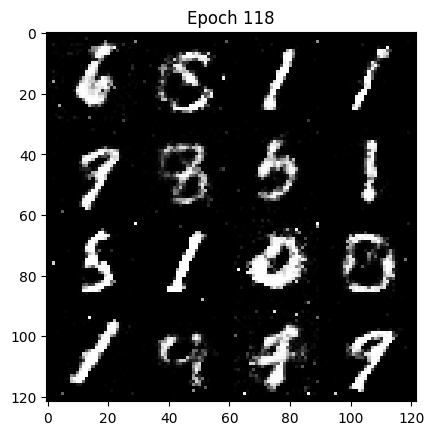

Epoch 119/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [119/200], D Loss: 0.9004, G Loss: 1.6470


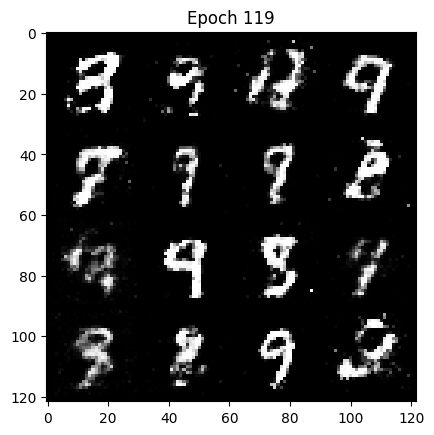

Epoch 120/200: 100%|██████████| 118/118 [01:03<00:00,  1.85it/s]


Epoch [120/200], D Loss: 0.8954, G Loss: 1.6505


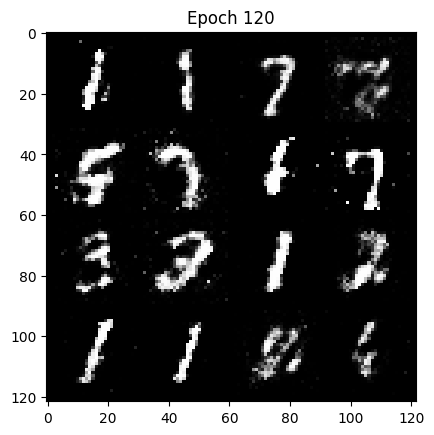

Epoch 121/200: 100%|██████████| 118/118 [01:05<00:00,  1.81it/s]


Epoch [121/200], D Loss: 0.9075, G Loss: 1.6368


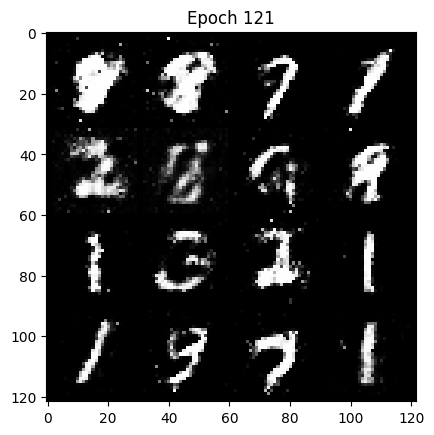

Epoch 122/200: 100%|██████████| 118/118 [01:05<00:00,  1.80it/s]


Epoch [122/200], D Loss: 0.8895, G Loss: 1.7237


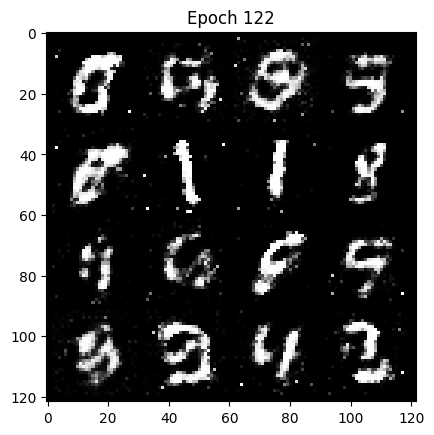

Epoch 123/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [123/200], D Loss: 0.9048, G Loss: 1.6531


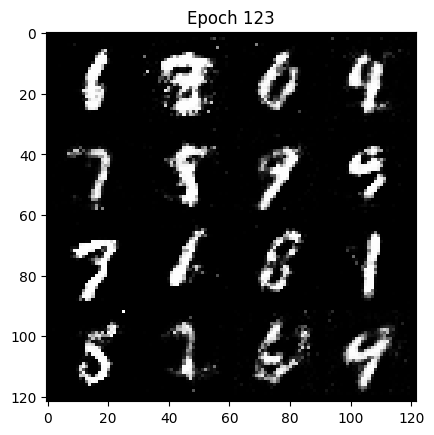

Epoch 124/200: 100%|██████████| 118/118 [01:02<00:00,  1.87it/s]


Epoch [124/200], D Loss: 0.9410, G Loss: 1.5625


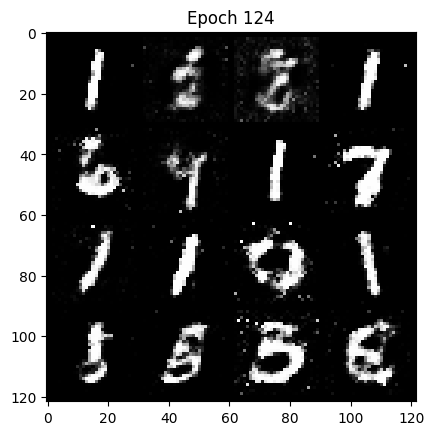

Epoch 125/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [125/200], D Loss: 0.9319, G Loss: 1.5766


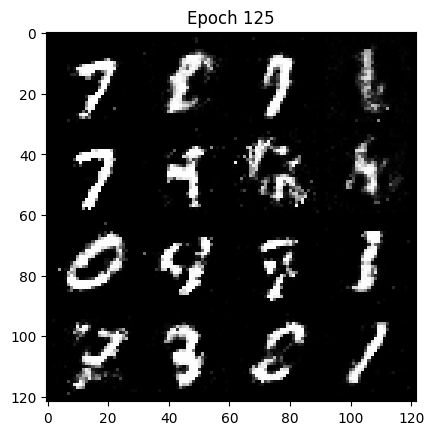

Epoch 126/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [126/200], D Loss: 0.9101, G Loss: 1.6502


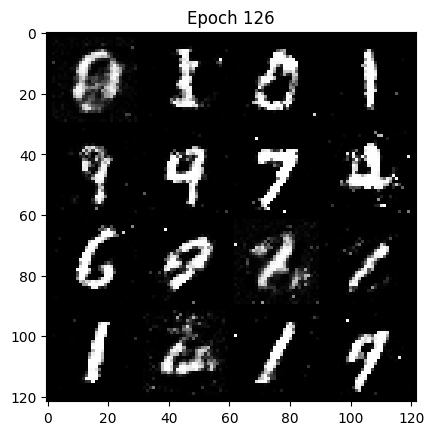

Epoch 127/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [127/200], D Loss: 0.8898, G Loss: 1.6821


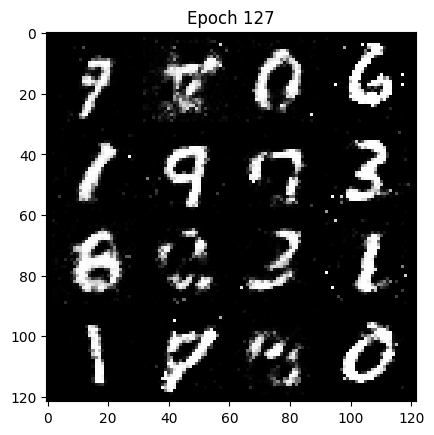

Epoch 128/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [128/200], D Loss: 0.9275, G Loss: 1.6468


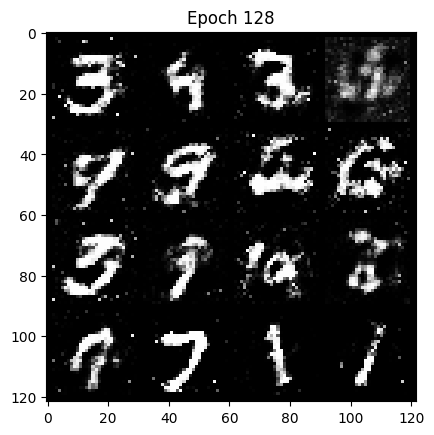

Epoch 129/200: 100%|██████████| 118/118 [01:01<00:00,  1.93it/s]


Epoch [129/200], D Loss: 0.9223, G Loss: 1.6167


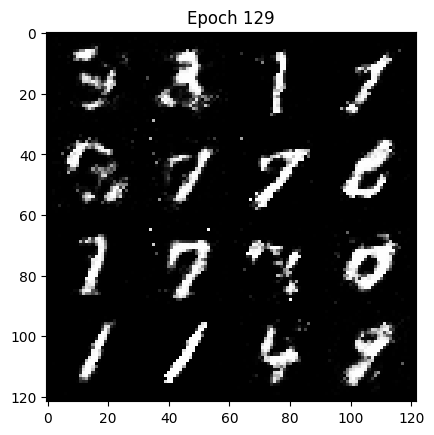

Epoch 130/200: 100%|██████████| 118/118 [01:02<00:00,  1.87it/s]


Epoch [130/200], D Loss: 0.9073, G Loss: 1.6383


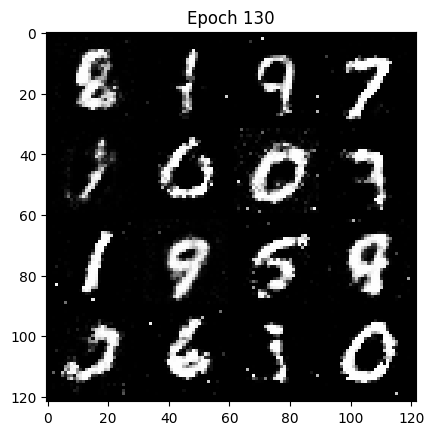

Epoch 131/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [131/200], D Loss: 0.9268, G Loss: 1.5738


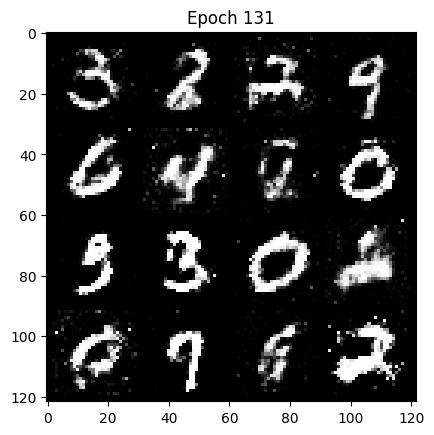

Epoch 132/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [132/200], D Loss: 0.9374, G Loss: 1.6050


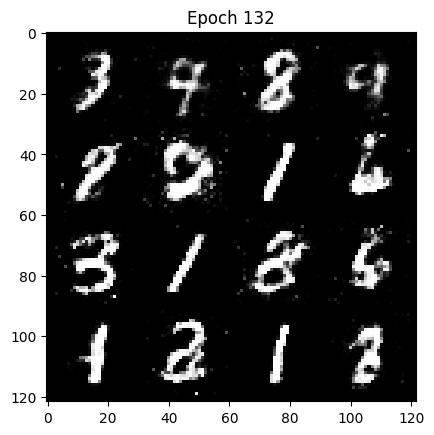

Epoch 133/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [133/200], D Loss: 0.9081, G Loss: 1.5911


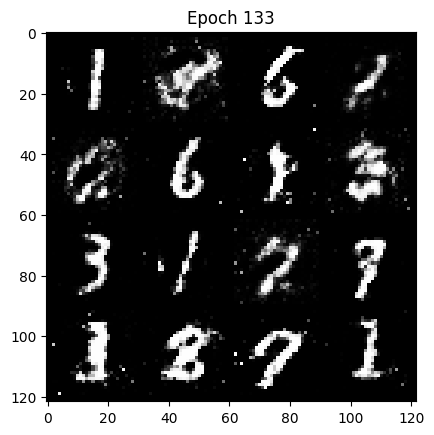

Epoch 134/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [134/200], D Loss: 0.9358, G Loss: 1.6163


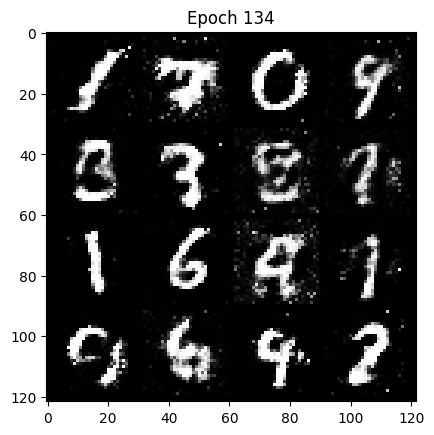

Epoch 135/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [135/200], D Loss: 0.9261, G Loss: 1.5644


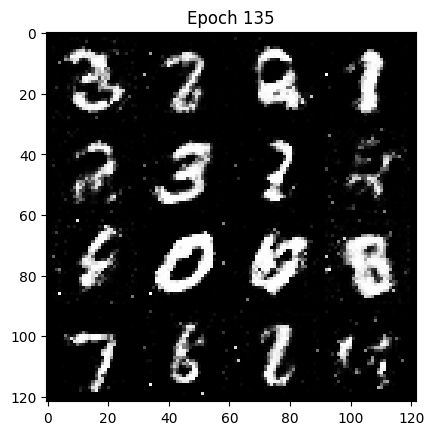

Epoch 136/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [136/200], D Loss: 0.9324, G Loss: 1.5700


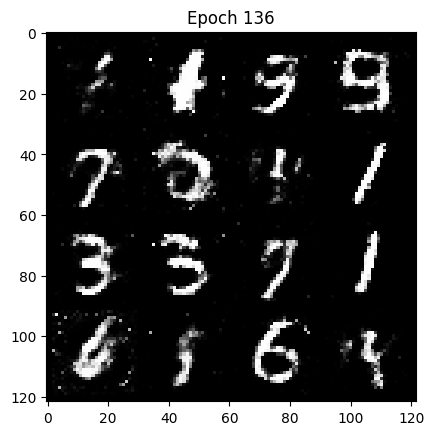

Epoch 137/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [137/200], D Loss: 0.9541, G Loss: 1.5372


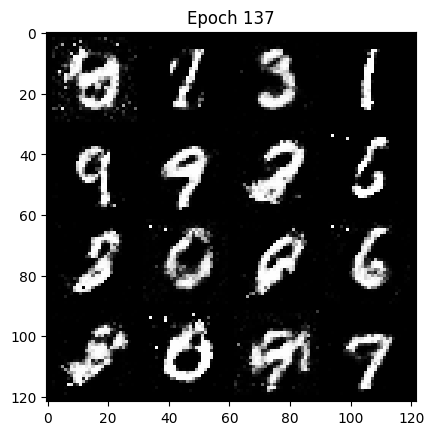

Epoch 138/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [138/200], D Loss: 0.9634, G Loss: 1.5170


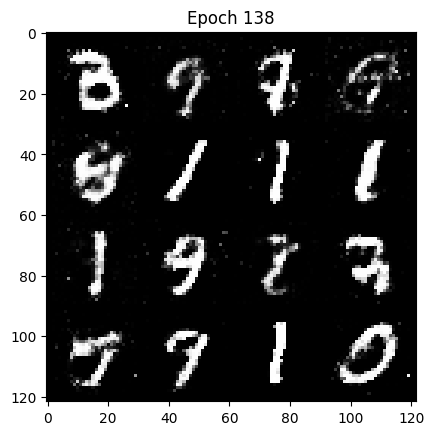

Epoch 139/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [139/200], D Loss: 0.9435, G Loss: 1.5516


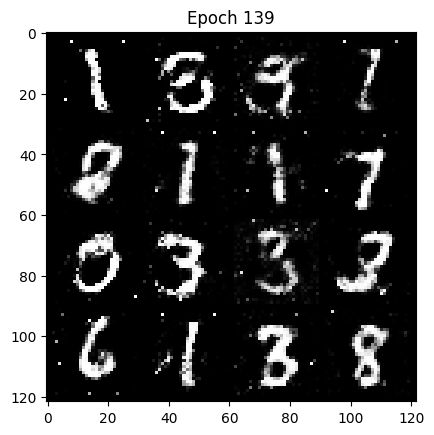

Epoch 140/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [140/200], D Loss: 0.9857, G Loss: 1.4333


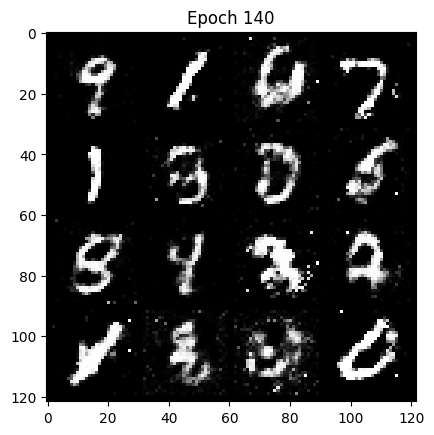

Epoch 141/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [141/200], D Loss: 0.9243, G Loss: 1.5860


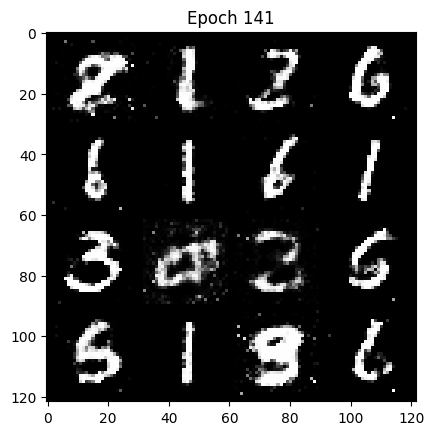

Epoch 142/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [142/200], D Loss: 1.0064, G Loss: 1.4728


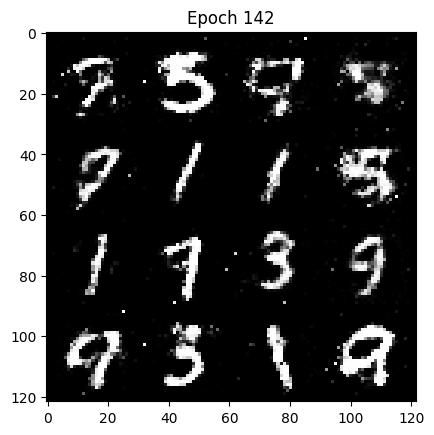

Epoch 143/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [143/200], D Loss: 0.9811, G Loss: 1.4857


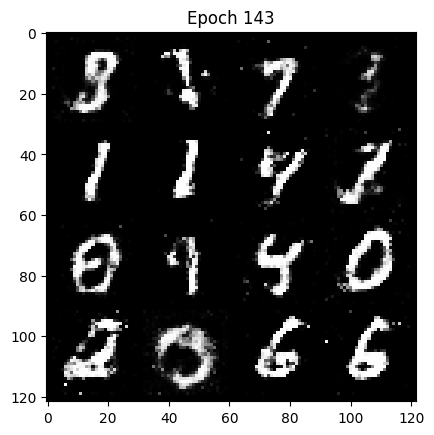

Epoch 144/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [144/200], D Loss: 0.9646, G Loss: 1.5471


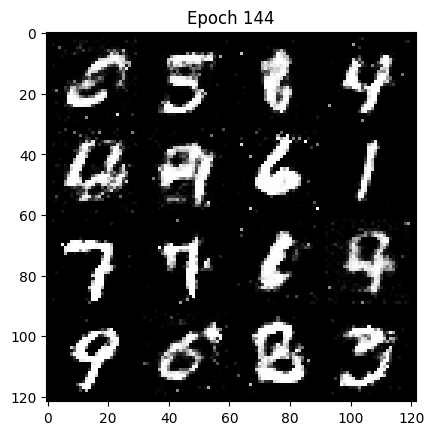

Epoch 145/200: 100%|██████████| 118/118 [01:03<00:00,  1.85it/s]


Epoch [145/200], D Loss: 0.9395, G Loss: 1.5426


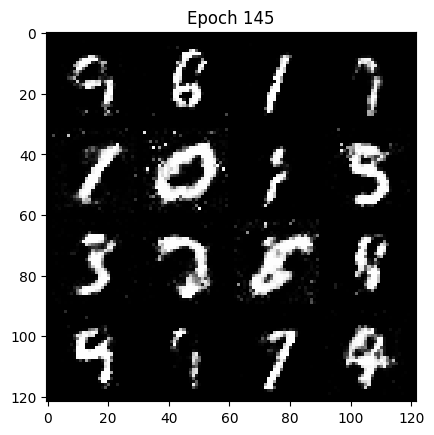

Epoch 146/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [146/200], D Loss: 0.9493, G Loss: 1.5171


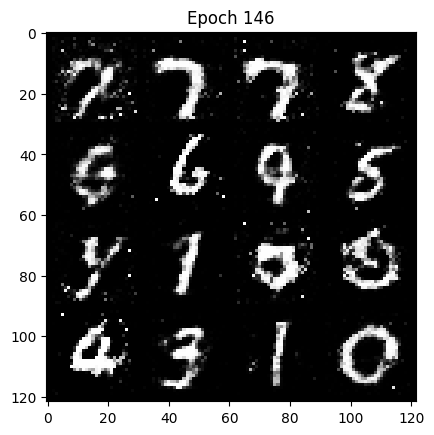

Epoch 147/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [147/200], D Loss: 0.9502, G Loss: 1.5201


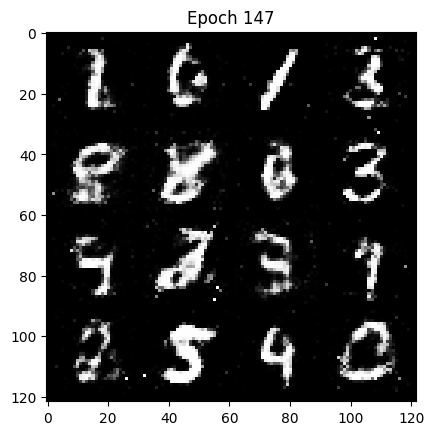

Epoch 148/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [148/200], D Loss: 0.9772, G Loss: 1.5002


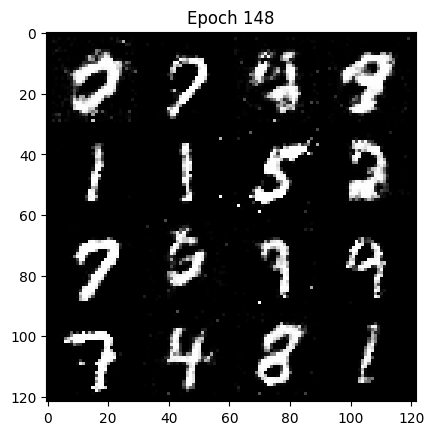

Epoch 149/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [149/200], D Loss: 0.9919, G Loss: 1.4614


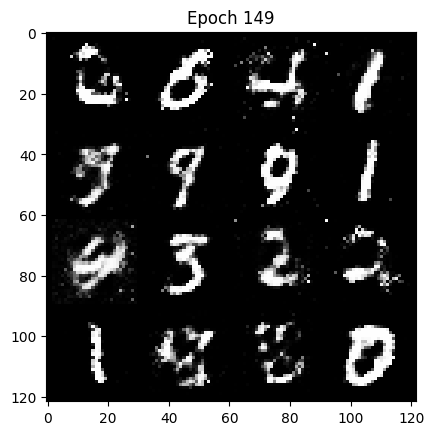

Epoch 150/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [150/200], D Loss: 0.9753, G Loss: 1.5007


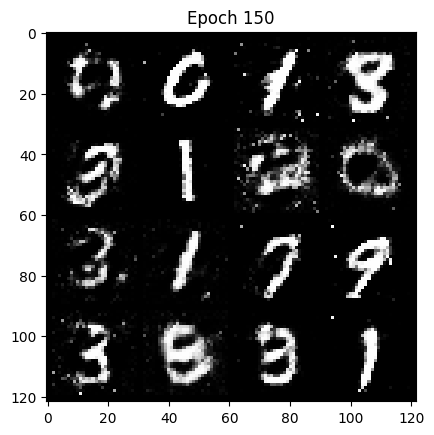

Epoch 151/200: 100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Epoch [151/200], D Loss: 1.0075, G Loss: 1.3867


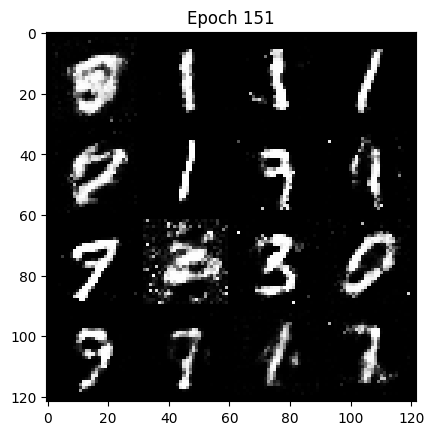

Epoch 152/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [152/200], D Loss: 0.9655, G Loss: 1.4707


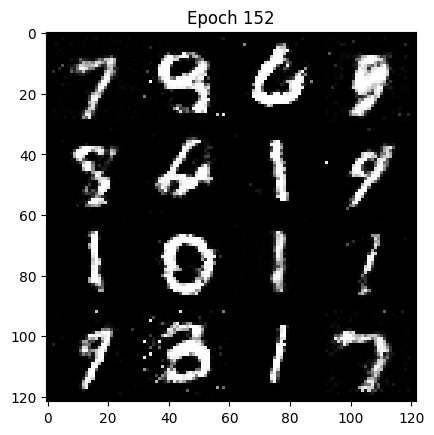

Epoch 153/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [153/200], D Loss: 1.0029, G Loss: 1.4090


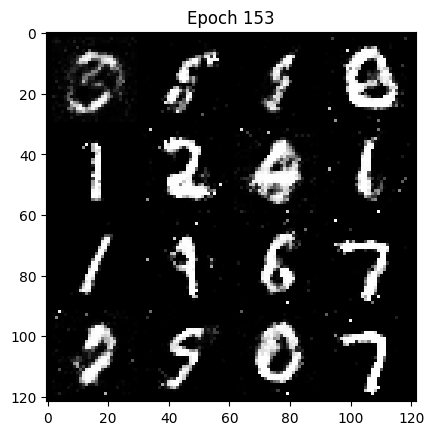

Epoch 154/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [154/200], D Loss: 0.9914, G Loss: 1.4109


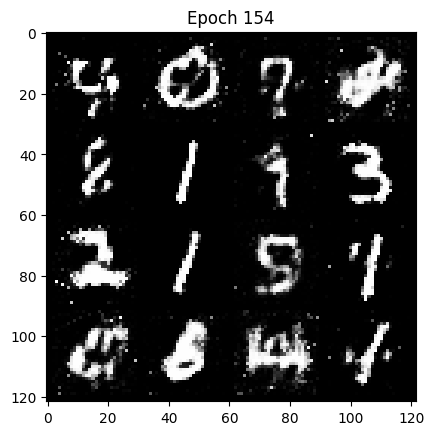

Epoch 155/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [155/200], D Loss: 0.9965, G Loss: 1.4340


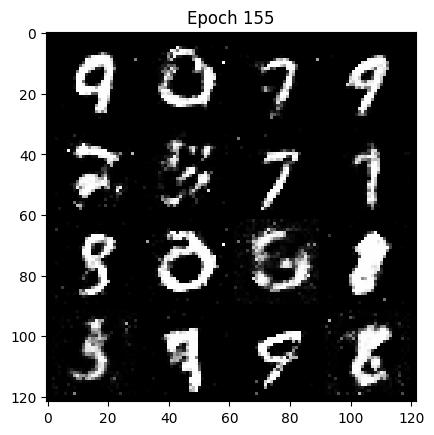

Epoch 156/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [156/200], D Loss: 0.9938, G Loss: 1.4353


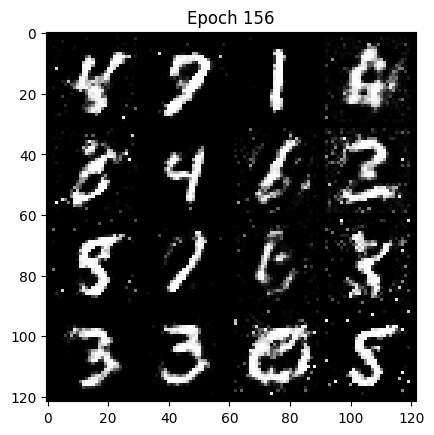

Epoch 157/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [157/200], D Loss: 1.0098, G Loss: 1.4123


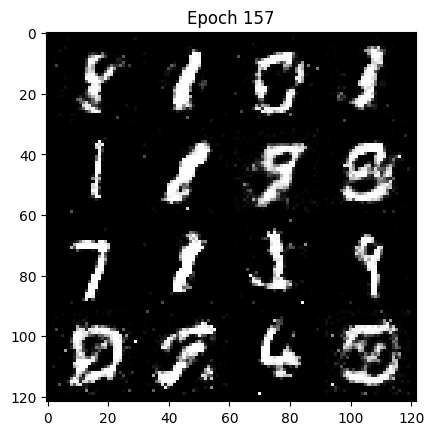

Epoch 158/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [158/200], D Loss: 1.0117, G Loss: 1.4097


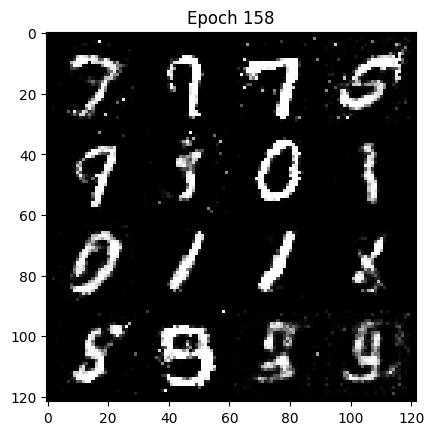

Epoch 159/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [159/200], D Loss: 1.0050, G Loss: 1.3971


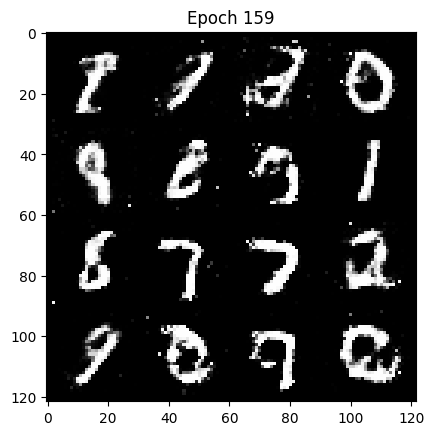

Epoch 160/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [160/200], D Loss: 1.0150, G Loss: 1.4160


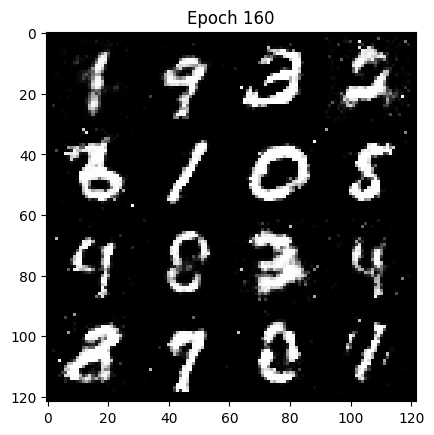

Epoch 161/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [161/200], D Loss: 1.0175, G Loss: 1.3783


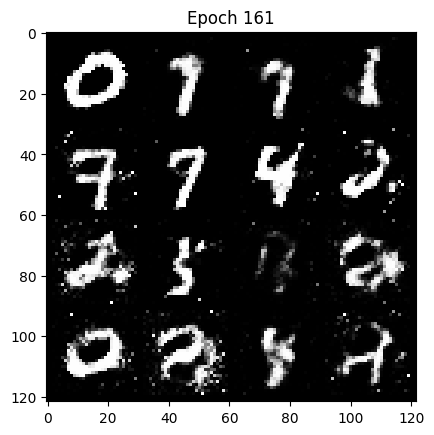

Epoch 162/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [162/200], D Loss: 1.0100, G Loss: 1.3673


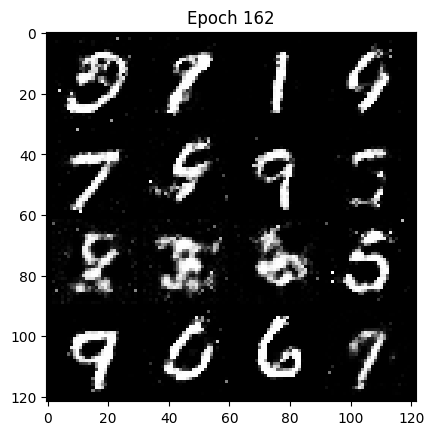

Epoch 163/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [163/200], D Loss: 1.0300, G Loss: 1.3961


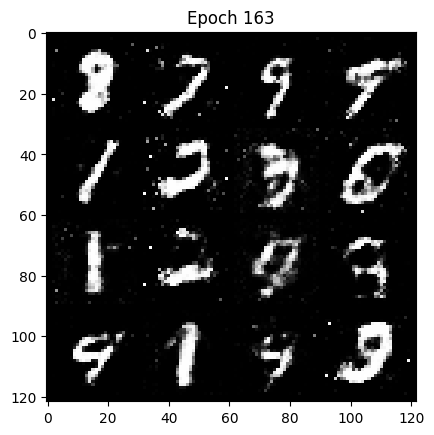

Epoch 164/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [164/200], D Loss: 1.0293, G Loss: 1.3578


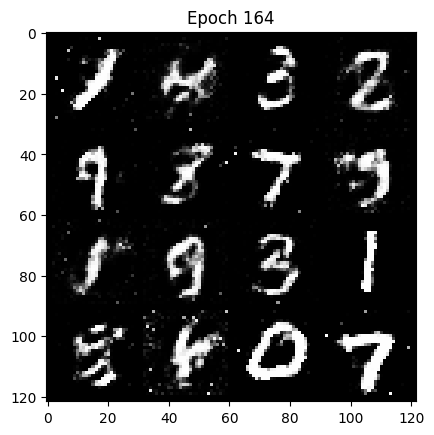

Epoch 165/200: 100%|██████████| 118/118 [01:10<00:00,  1.67it/s]


Epoch [165/200], D Loss: 1.0209, G Loss: 1.3893


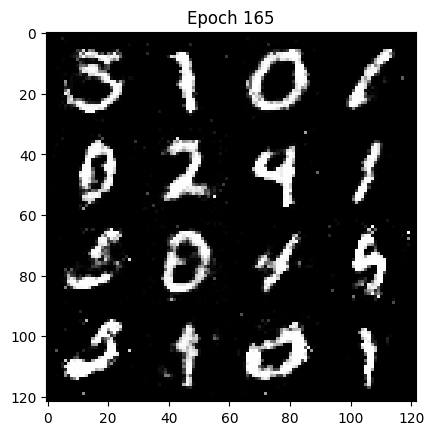

Epoch 166/200: 100%|██████████| 118/118 [01:06<00:00,  1.77it/s]


Epoch [166/200], D Loss: 1.0216, G Loss: 1.3754


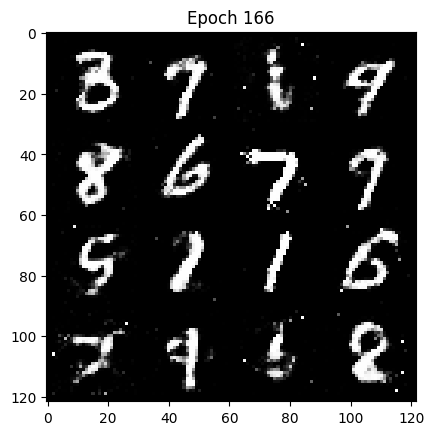

Epoch 167/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [167/200], D Loss: 1.0228, G Loss: 1.3915


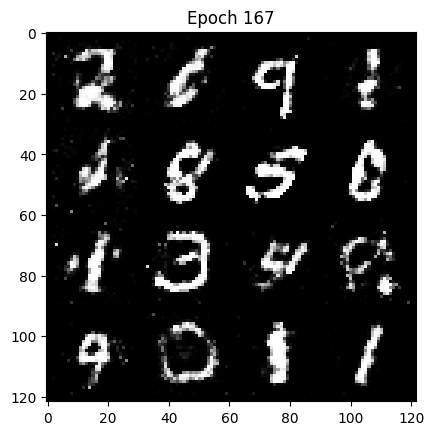

Epoch 168/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [168/200], D Loss: 1.0212, G Loss: 1.3866


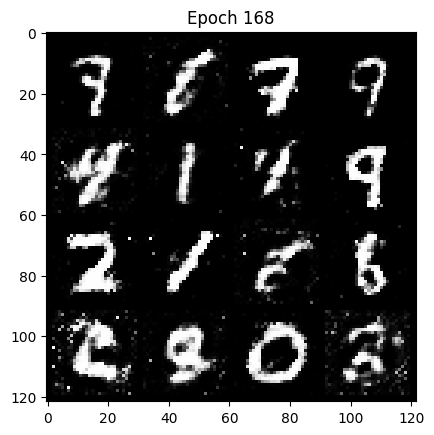

Epoch 169/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [169/200], D Loss: 1.0295, G Loss: 1.3702


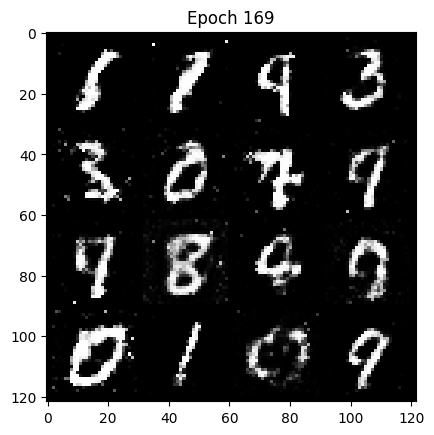

Epoch 170/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [170/200], D Loss: 1.0285, G Loss: 1.3371


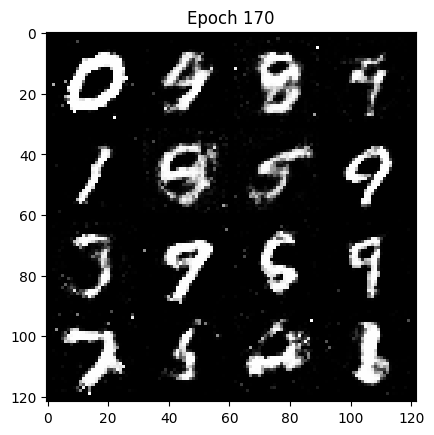

Epoch 171/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [171/200], D Loss: 1.0176, G Loss: 1.3889


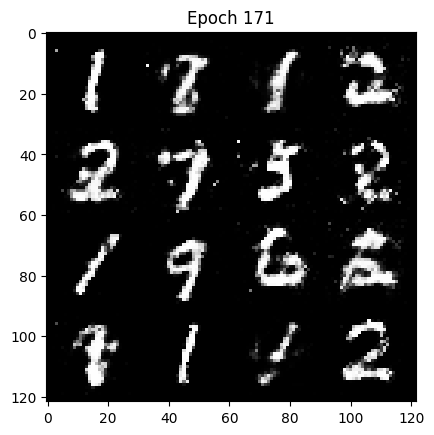

Epoch 172/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [172/200], D Loss: 1.0377, G Loss: 1.3811


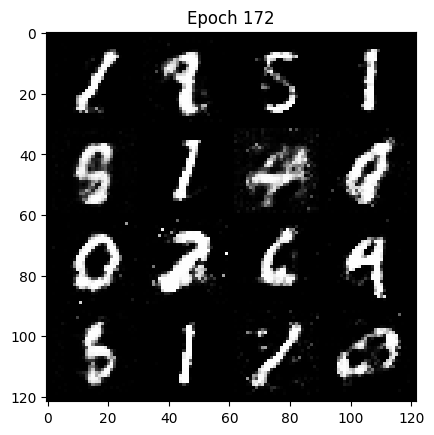

Epoch 173/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [173/200], D Loss: 1.0442, G Loss: 1.3284


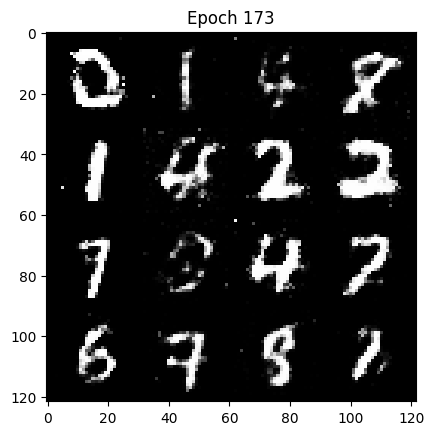

Epoch 174/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [174/200], D Loss: 1.0345, G Loss: 1.3284


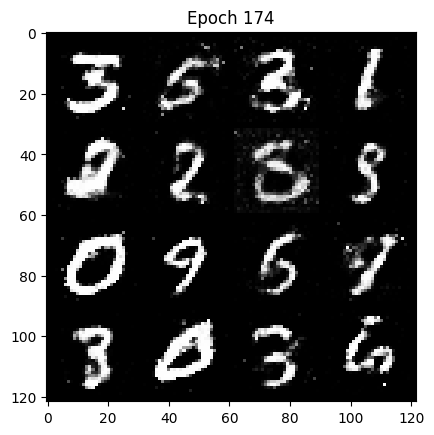

Epoch 175/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [175/200], D Loss: 1.0290, G Loss: 1.3333


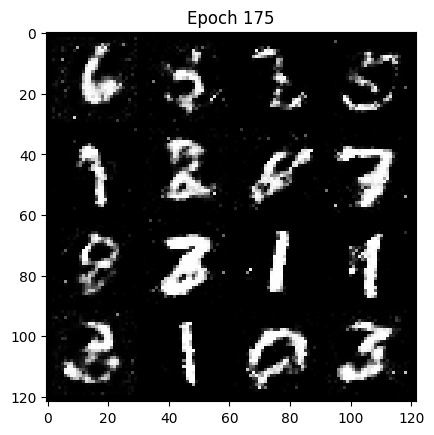

Epoch 176/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [176/200], D Loss: 1.0379, G Loss: 1.3304


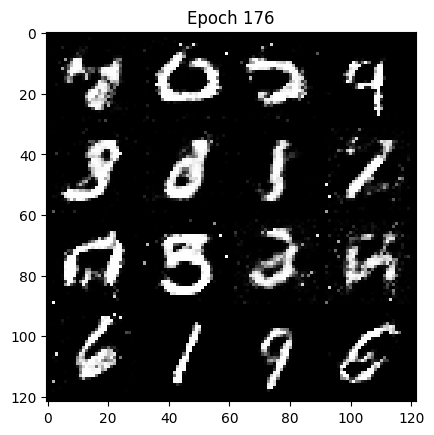

Epoch 177/200: 100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


Epoch [177/200], D Loss: 1.0622, G Loss: 1.3455


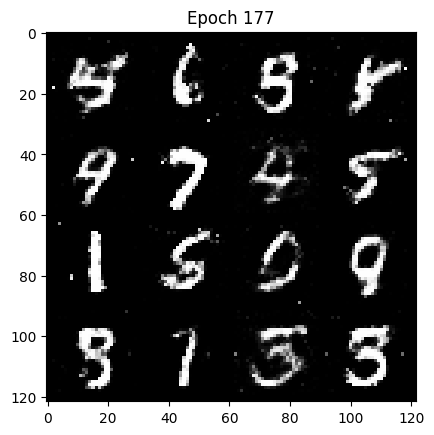

Epoch 178/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [178/200], D Loss: 1.0550, G Loss: 1.3137


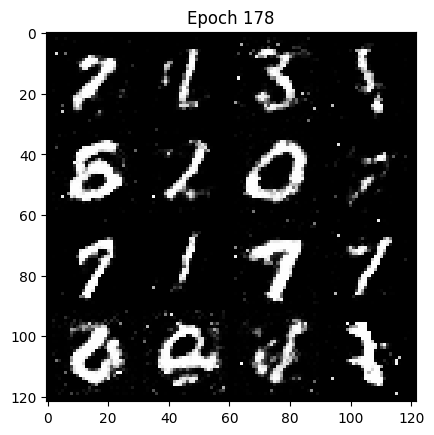

Epoch 179/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [179/200], D Loss: 1.0561, G Loss: 1.3025


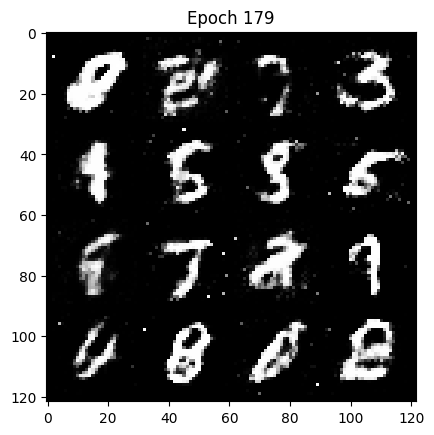

Epoch 180/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [180/200], D Loss: 1.0530, G Loss: 1.2757


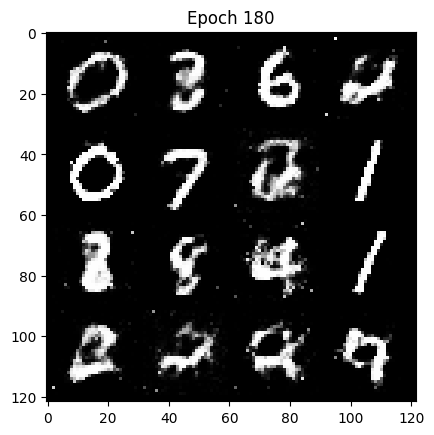

Epoch 181/200: 100%|██████████| 118/118 [01:02<00:00,  1.87it/s]


Epoch [181/200], D Loss: 1.0489, G Loss: 1.3149


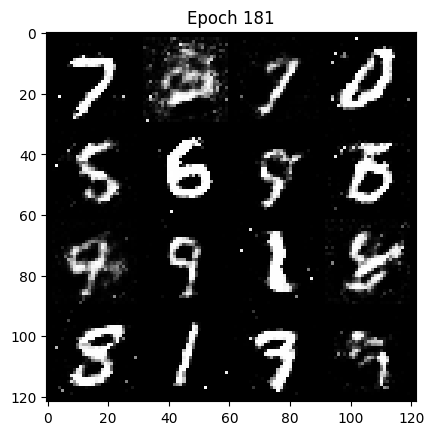

Epoch 182/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [182/200], D Loss: 1.0545, G Loss: 1.3017


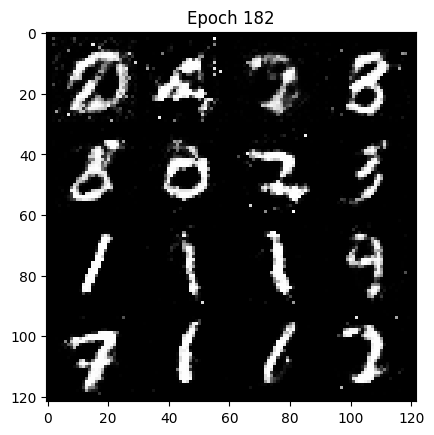

Epoch 183/200: 100%|██████████| 118/118 [01:01<00:00,  1.90it/s]


Epoch [183/200], D Loss: 1.0710, G Loss: 1.2405


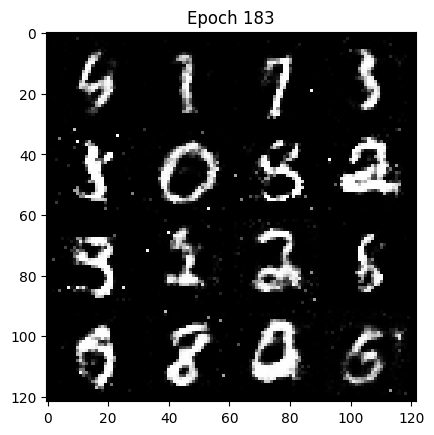

Epoch 184/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [184/200], D Loss: 1.0669, G Loss: 1.2838


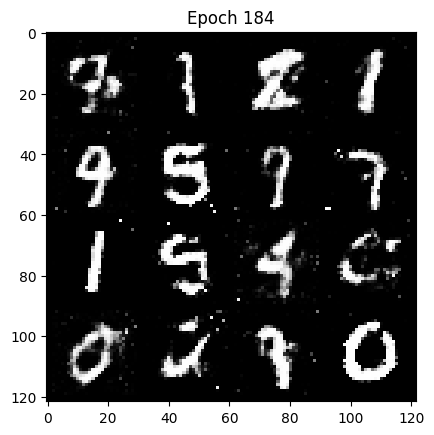

Epoch 185/200: 100%|██████████| 118/118 [01:03<00:00,  1.85it/s]


Epoch [185/200], D Loss: 1.0702, G Loss: 1.3229


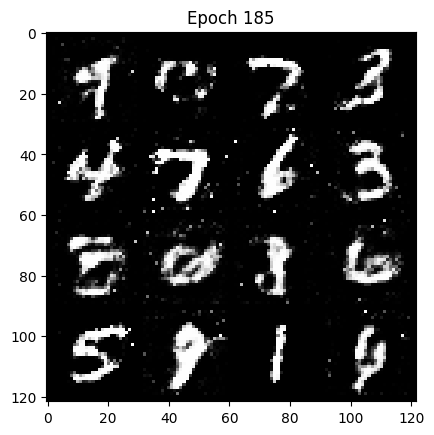

Epoch 186/200: 100%|██████████| 118/118 [01:02<00:00,  1.90it/s]


Epoch [186/200], D Loss: 1.0714, G Loss: 1.2769


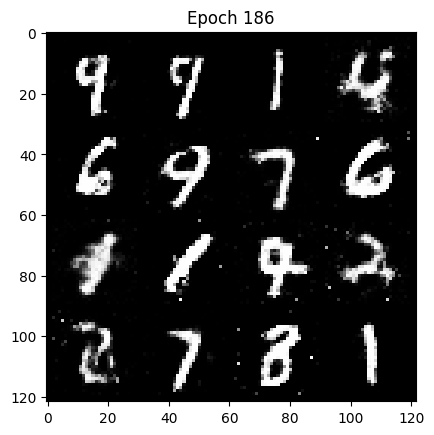

Epoch 187/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [187/200], D Loss: 1.0804, G Loss: 1.2400


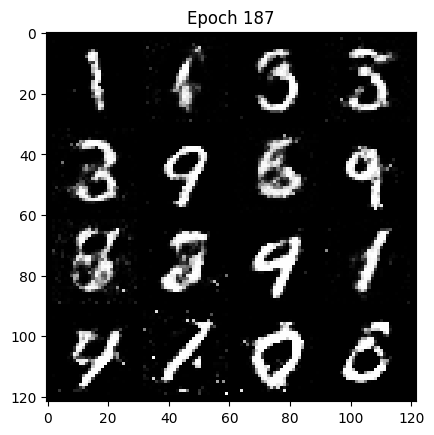

Epoch 188/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [188/200], D Loss: 1.0845, G Loss: 1.2119


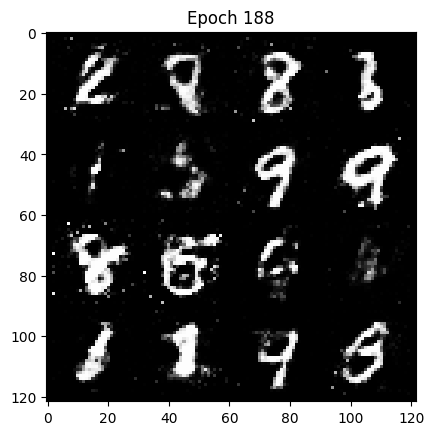

Epoch 189/200: 100%|██████████| 118/118 [01:02<00:00,  1.89it/s]


Epoch [189/200], D Loss: 1.0474, G Loss: 1.3289


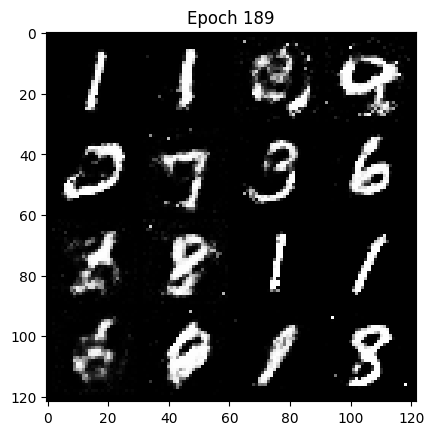

Epoch 190/200: 100%|██████████| 118/118 [01:03<00:00,  1.85it/s]


Epoch [190/200], D Loss: 1.0715, G Loss: 1.2450


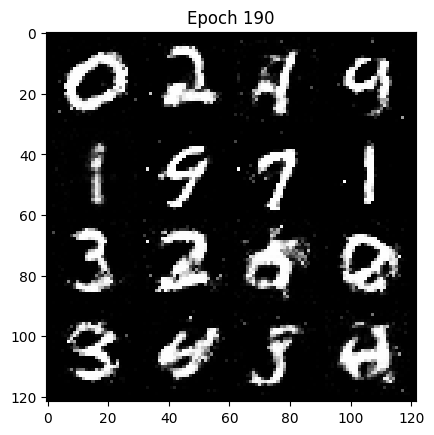

Epoch 191/200: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s]


Epoch [191/200], D Loss: 1.0812, G Loss: 1.2396


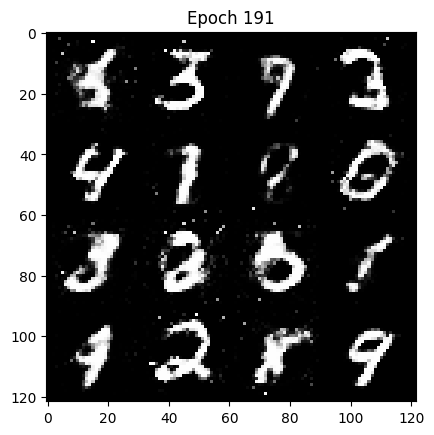

Epoch 192/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [192/200], D Loss: 1.0571, G Loss: 1.3066


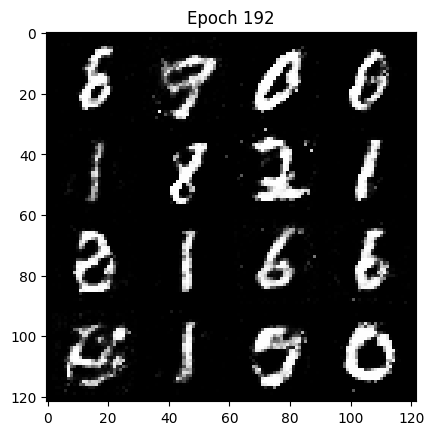

Epoch 193/200: 100%|██████████| 118/118 [01:03<00:00,  1.84it/s]


Epoch [193/200], D Loss: 1.0994, G Loss: 1.2263


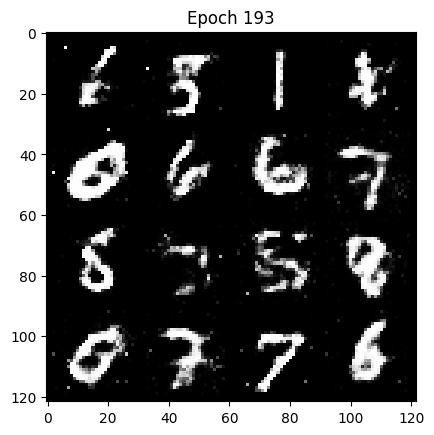

Epoch 194/200: 100%|██████████| 118/118 [01:03<00:00,  1.85it/s]


Epoch [194/200], D Loss: 1.0793, G Loss: 1.2473


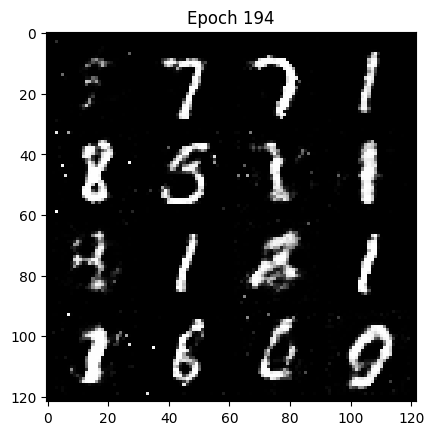

Epoch 195/200: 100%|██████████| 118/118 [01:02<00:00,  1.88it/s]


Epoch [195/200], D Loss: 1.0843, G Loss: 1.2343


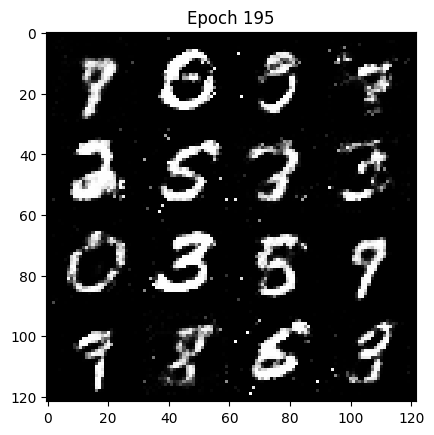

Epoch 196/200: 100%|██████████| 118/118 [01:03<00:00,  1.85it/s]


Epoch [196/200], D Loss: 1.0750, G Loss: 1.2843


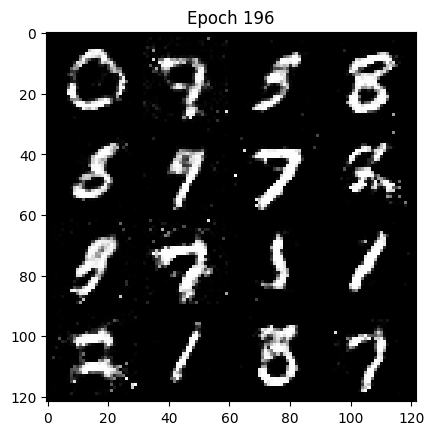

Epoch 197/200: 100%|██████████| 118/118 [01:04<00:00,  1.84it/s]


Epoch [197/200], D Loss: 1.0668, G Loss: 1.2636


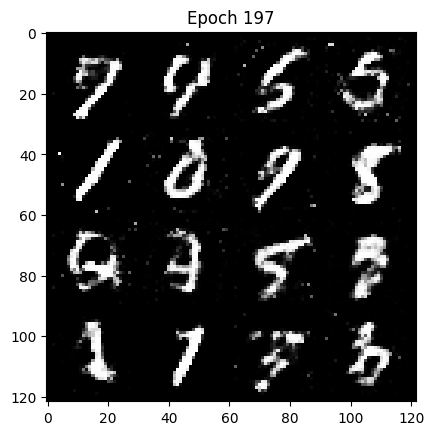

Epoch 198/200: 100%|██████████| 118/118 [01:03<00:00,  1.87it/s]


Epoch [198/200], D Loss: 1.0868, G Loss: 1.2491


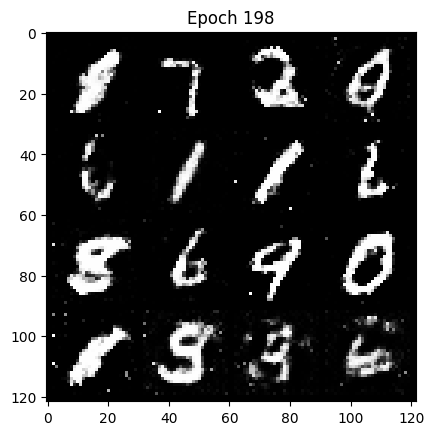

Epoch 199/200: 100%|██████████| 118/118 [01:03<00:00,  1.84it/s]


Epoch [199/200], D Loss: 1.0820, G Loss: 1.2428


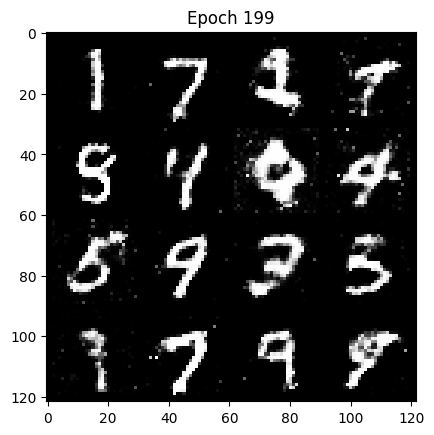

Epoch 200/200: 100%|██████████| 118/118 [01:04<00:00,  1.84it/s]


Epoch [200/200], D Loss: 1.0737, G Loss: 1.2686


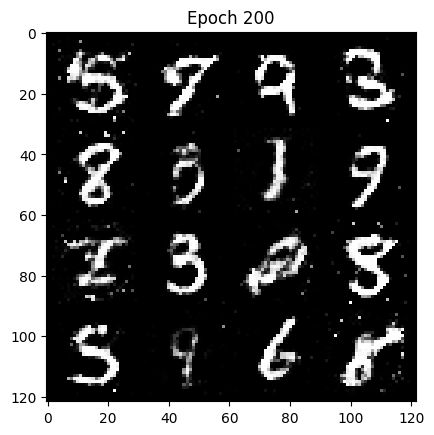

In [ ]:
generator.train()
discriminator.train()

for epoch in range(num_epochs):
  g_loss_epoch = 0.0
  d_loss_epoch = 0.0

  for i, (imgs, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
    real_imgs = imgs.view(-1, 784).to(device)

    # Generate fake images
    z = torch.randn(batch_size, latent_dim).to(device)
    fake_imgs = generator(z)

    # Train Discriminator
    d_loss = train_discriminator(real_imgs, fake_imgs.detach())
    d_loss_epoch += d_loss.item()

    # Train Generator
    g_loss = train_generator(fake_imgs)
    g_loss_epoch += g_loss.item()

  # Calculate average losses for the epoch
  g_loss_epoch /= len(train_loader)
  d_loss_epoch /= len(train_loader)

  # Store losses for visualization
  g_losses.append(g_loss_epoch)
  d_losses.append(d_loss_epoch)

  # Print losses for the epoch
  print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss_epoch:.4f}, G Loss: {g_loss_epoch:.4f}")

  # Visualize generated images at the end of each epoch
  show_generated_imgs(epoch+1, generator, latent_dim)

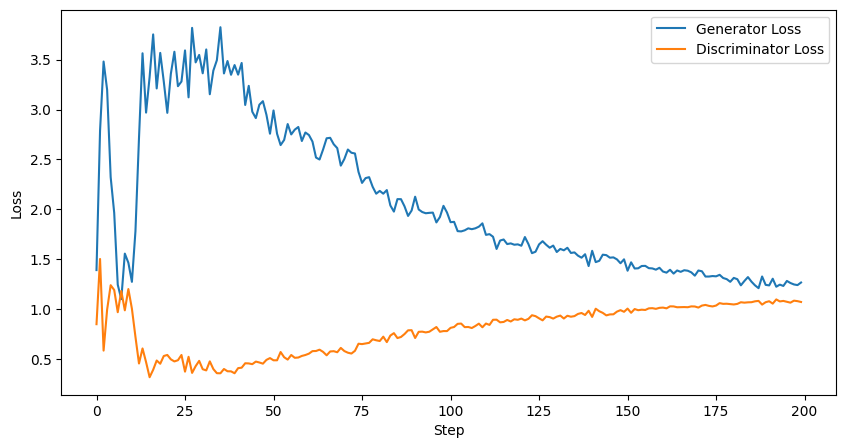

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()